## set up notebook

In [1]:
#reload when modified
%load_ext autoreload
%autoreload 2
#activate r magic
%load_ext rpy2.ipython
%matplotlib inline

In [2]:
import sys
#sys.add()
sys.path.append('../polisome/utilities')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utilities as UT
import missingno as msno
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc

random.seed(1976)
np.random.seed(1976)

# Data Anaylsis

## Experiment SetUp

In [3]:
#from IPython.display import Image

In [4]:
# <img src="Figures/Figure_1.jpeg" width="800" height="800" />

In [5]:
#create a dictionary of gene to desc
#from the gff file
def make_desc(_GFF):
    gff =pd.read_csv( _GFF, sep='\t', header=None, comment='#')
    
    gff = gff[gff.iloc[:,2]=='gene']
    #print( gff[gff[gff.columns[-1]].str.contains('Tb427_020006200')] )
    desc = {}
    for n in gff.iloc[:,-1]:
        n=n.replace('%2C',' ')
        item_list = n.split(';')
        #print (item_list)
        temp_dict = {}
        for m in item_list:
            #print(m)
            temp_dict[m.split('=')[0].strip()]=m.split('=')[1].strip()
        #print(temp_dict['ID'])
        #print(temp_dict['description'])
        desc[temp_dict['ID']]=temp_dict.get('description','none')
    return desc

desc_dict = make_desc('../polisome/InData/TriTrypDB-46_TbruceiTREU927.gff')
desc_dict['Tb10.v4.0073']

'variant surface glycoprotein (VSG  pseudogene)  putative'

In [6]:
#combine read counts
exp = '{life_stage}_{fraction}_{replica}'
list_df = [exp.format(
    life_stage=life_stage,
    fraction=fraction,
    replica=replica) 
 for life_stage in ['B','P']
 for fraction in ['tot','pol','sub']
 for replica in ['1','2','3']
            ]
list_df = [n+'/res_cds/counts.txt' for n in list_df]
list_df =[pd.read_csv(n,index_col=[0],comment='#',sep='\t') for n in list_df]
df = list_df[0].copy()
for temp_df in list_df[1:]:
    df = df.join(temp_df.iloc[:,-1])
df.head()
#temp_df = pd.read_csv('BSF/tb927_3_ks_counts_final.txt',index_col=[0],comment='#',sep='\t')

,Chr,Start,End,Strand,Length,/tmp/230561.1.all.q/B_tot_1/B_tot_1_sorted.bam,/tmp/230564.1.all.q/B_tot_2/B_tot_2_sorted.bam,/tmp/230567.1.all.q/B_tot_3/B_tot_3_sorted.bam,/tmp/230560.1.all.q/B_pol_1/B_pol_1_sorted.bam,/tmp/230563.1.all.q/B_pol_2/B_pol_2_sorted.bam,...,/tmp/230568.1.all.q/B_sub_3/B_sub_3_sorted.bam,/tmp/230570.1.all.q/P_tot_1/P_tot_1_sorted.bam,/tmp/230573.1.all.q/P_tot_2/P_tot_2_sorted.bam,/tmp/230576.1.all.q/P_tot_3/P_tot_3_sorted.bam,/tmp/230569.1.all.q/P_pol_1/P_pol_1_sorted.bam,/tmp/230572.1.all.q/P_pol_2/P_pol_2_sorted.bam,/tmp/230575.1.all.q/P_pol_3/P_pol_3_sorted.bam,/tmp/230571.1.all.q/P_sub_1/P_sub_1_sorted.bam,/tmp/230574.1.all.q/P_sub_2/P_sub_2_sorted.bam,/tmp/230577.1.all.q/P_sub_3/P_sub_3_sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
Tb10.v4.0073,tryp_X-188b09.p2kB601,929,1489,+,561,1,1,0,0,0,...,2,0,1,2,0,0,0,0,0,0
Tb10.v4.0074,tryp_X-188b09.p2kB601,2775,3452,+,678,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
Tb10.v4.0075,tryp_X-188b09.p2kB601,3781,5223,+,1443,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Tb10.v4.0076,tryp_X-188b09.p2kB601,6264,7721,+,1458,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0077,tryp_X-188b09.p2kB601,9669,10955,+,1287,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
data_col = df.columns[5:]
data_col

Index(['/tmp/230561.1.all.q/B_tot_1/B_tot_1_sorted.bam',
       '/tmp/230564.1.all.q/B_tot_2/B_tot_2_sorted.bam',
       '/tmp/230567.1.all.q/B_tot_3/B_tot_3_sorted.bam',
       '/tmp/230560.1.all.q/B_pol_1/B_pol_1_sorted.bam',
       '/tmp/230563.1.all.q/B_pol_2/B_pol_2_sorted.bam',
       '/tmp/230566.1.all.q/B_pol_3/B_pol_3_sorted.bam',
       '/tmp/230562.1.all.q/B_sub_1/B_sub_1_sorted.bam',
       '/tmp/230565.1.all.q/B_sub_2/B_sub_2_sorted.bam',
       '/tmp/230568.1.all.q/B_sub_3/B_sub_3_sorted.bam',
       '/tmp/230570.1.all.q/P_tot_1/P_tot_1_sorted.bam',
       '/tmp/230573.1.all.q/P_tot_2/P_tot_2_sorted.bam',
       '/tmp/230576.1.all.q/P_tot_3/P_tot_3_sorted.bam',
       '/tmp/230569.1.all.q/P_pol_1/P_pol_1_sorted.bam',
       '/tmp/230572.1.all.q/P_pol_2/P_pol_2_sorted.bam',
       '/tmp/230575.1.all.q/P_pol_3/P_pol_3_sorted.bam',
       '/tmp/230571.1.all.q/P_sub_1/P_sub_1_sorted.bam',
       '/tmp/230574.1.all.q/P_sub_2/P_sub_2_sorted.bam',
       '/tmp/230577.1.all.q/P_s

In [21]:
#change headers
indata = df[data_col]
indata.columns = [n.split('/')[3].replace('_sorted.bam','') for  n in indata.columns]
indata.head()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Geneid,,,,,,,,,,,,,,,,,,
Tb10.v4.0073,1,1,0,0,0,0,1,0,2,0,1,2,0,0,0,0,0,0
Tb10.v4.0074,0,1,0,1,0,0,1,2,1,0,0,0,0,0,0,0,0,0
Tb10.v4.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Tb10.v4.0076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0077,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [22]:
print(indata.shape)
indata=indata.dropna()
print(indata.shape)

(13222, 18)
(13222, 18)


In [31]:
indata['mean_pol_b'] = indata[['B_pol_1','B_pol_2','B_pol_3']].mean(axis=1)
indata['mean_pol_p'] = indata[['P_pol_1','P_pol_2','P_pol_3']].mean(axis=1)
indata['mean_pol_b_rank'] = indata['mean_pol_b'].rank(method='min')
indata['mean_pol_p_rank'] = indata['mean_pol_p'].rank(method='min')
indata=indata.sort_values('mean_pol_b_rank')

In [32]:
indata.tail()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,...,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3,mean_pol_b,mean_pol_p,mean_pol_b_rank,mean_pol_p_rank
Geneid,,,,,,,,,,,,,,,,,,,,,
Tb927.1.2340,46652,43852,40278,89896,126115,122315,7458,6049,8188,82129,...,67294,75461,76171,15821,21190,17700,112775.333333,72975.333333,13218.0,13217.0
Tb927.1.2380,46401,43700,40370,89949,126574,122305,7365,6274,8080,82188,...,66697,75023,75770,15963,21379,18083,112942.666667,72496.666667,13219.0,13216.0
Tb927.1.2360,46669,43533,40440,90188,126570,122267,7479,6280,8210,82182,...,67263,75322,76430,15962,21024,17906,113008.333333,73005.000000,13220.0,13218.0
KS17gene_4602a,104691,94300,100973,112869,153663,160177,126919,119628,156442,106342,...,101135,110887,99022,92830,145128,155988,142236.333333,103681.333333,13221.0,13222.0
gene-Tb427.BES40.22,1207264,1260320,1128244,151125,218044,214241,81919,140590,110533,8795,...,591,1345,778,708,1285,10021,194470.000000,904.666667,13222.0,6639.0


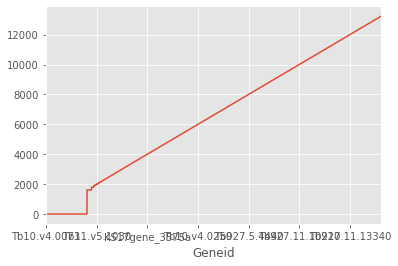

In [30]:
indata['mean_pol_p_rank'].plot()

In [34]:
print(len(indata['mean_pol_b_rank'].unique()))
indata.loc['Tb927.11.11750']


7526


B_tot_1            2190.000000
B_tot_2            1897.000000
B_tot_3            1918.000000
B_pol_1            1216.000000
B_pol_2            1347.000000
B_pol_3            1244.000000
B_sub_1            2323.000000
B_sub_2            2174.000000
B_sub_3            1787.000000
P_tot_1            2422.000000
P_tot_2            2460.000000
P_tot_3            2036.000000
P_pol_1             610.000000
P_pol_2             910.000000
P_pol_3             911.000000
P_sub_1            1725.000000
P_sub_2            2187.000000
P_sub_3            1938.000000
mean_pol_b         1269.000000
mean_pol_p          810.333333
mean_pol_b_rank    7089.000000
mean_pol_p_rank    6265.000000
Name: Tb927.11.11750, dtype: float64

## QC - MSD
visualise differences between samples

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


{'r': 'BSF', 'b': 'PCF'}


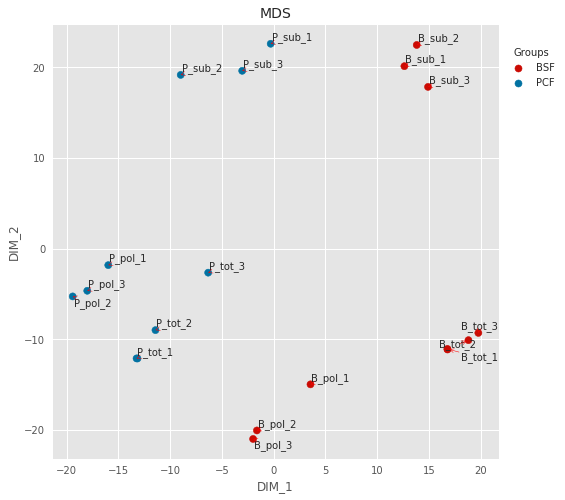

In [172]:
plt.style.use('ggplot')
palette = ['r']*9+['b']*9
fig,ax = plt.subplots(figsize=(8,8), ncols=1, nrows=1)
UT.make_mds(np.log2(indata),palette,ax,color_dictionary={'r':'BSF','b':'PCF'})
#plt.savefig('Figures/Figure_2.png')
plt.show()

## Compute Length and GC content

In [173]:
!mkdir -p InData

In [174]:
!gtf2bed < genomes/tb927_11/tb927_11.gtf > tb927_11.bed
!bedtools nuc -fi genomes/tb927_11/tb927_11.fa -bed tb927_11.bed >InData/GC_content_927.txt

In [175]:
#function to extract the gene info
#from the "bedtools nuc -fi" outputs
def get_gene_ids(n):
    res = {}
    temp = n.split(';')
    temp =[n.strip() for n in temp if len(n)>2]
    for f in temp:
        if 'zero_length' in f:
            continue
        key = f.split(' ')[0]
        value = f.split(' ')[1]
        key=key.replace('\"','').replace('\'','').strip()
        value=value.replace('\"','').replace('\'','').strip()
        res[key]=value
    return res['gene_id']

In [176]:
#gc_content = pd.read_csv('InData/GC_content_927.txt',sep='\t')
#gc_content = gc_content[gc_content['8_usercol']=='CDS']
#gc_content['gene_id'] = [get_gene_ids(n) for n in gc_content['10_usercol']]

In [177]:
gc_content = gc_content.drop_duplicates('gene_id')
gc_content.set_index('gene_id',inplace=True)
gc_content=gc_content[['19_seq_len','12_pct_gc']]
gc_content.columns = ['length', 'gccontent']
gc_content.head()#create a dataframe with only GC and length
#for each gene
gc_content = pd.read_csv('InData/GC_content_927.txt',sep='\t')
#print(gc_content.shape)
gc_content = gc_content[gc_content['8_usercol']=='CDS']
gc_content['gene_id'] = [get_gene_ids(n) for n in gc_content['10_usercol']]


,length,gccontent
gene_id,,
Tb07.11L3.90,1131,0.510168
Tb07.11L3.100,3795,0.500132
KS17gene_4354a,8882,0.465999
KS17gene_4353a,4093,0.416076
Tb05.5K5.10,72,0.402778


In [178]:
#gc_content = pd.read_csv('InData/GC_content_927.txt',sep='\t')
#gc_content.head()

In [179]:
#[n for n in gc_content.index.values if 'KS' in n]

In [180]:
#use only gene with a read count
print(indata.shape)
indata=indata.join(gc_content,how='inner')
gc_content = gc_content[['length', 'gccontent']]
indata.drop(['length', 'gccontent'],axis=1,inplace=True) 
indata.head()

(13222, 18)


,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb10.v4.0073,1,1,0,0,0,0,1,0,2,0,1,2,0,0,0,0,0,0
Tb10.v4.0074,0,1,0,1,0,0,1,2,1,0,0,0,0,0,0,0,0,0
Tb10.v4.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Tb10.v4.0076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tb10.v4.0077,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [181]:
#[n for n in indata.index.values if 'gene-' in n]

## Data Normalization

### edgeR to filter low counts

In [182]:
%%R -i indata
options(warn=-1)
library("limma") 
library("edgeR")
head(indata)

             B_tot_1 B_tot_2 B_tot_3 B_pol_1 B_pol_2 B_pol_3 B_sub_1 B_sub_2
Tb10.v4.0073       1       1       0       0       0       0       1       0
Tb10.v4.0074       0       1       0       1       0       0       1       2
Tb10.v4.0075       0       0       0       0       0       0       0       0
Tb10.v4.0076       0       0       0       0       0       0       0       0
Tb10.v4.0077       0       0       0       1       0       0       0       0
Tb10.v4.0078       1       0       1       1       0       8       1       5
             B_sub_3 P_tot_1 P_tot_2 P_tot_3 P_pol_1 P_pol_2 P_pol_3 P_sub_1
Tb10.v4.0073       2       0       1       2       0       0       0       0
Tb10.v4.0074       1       0       0       0       0       0       0       0
Tb10.v4.0075       0       0       0       0       0       0       0       1
Tb10.v4.0076       0       0       0       0       0       0       0       0
Tb10.v4.0077       0       0       0       0       0       0       0       0

In [183]:
%%R
group <- factor(c(
    'Btot','Btot','Btot',
    'Bpol','Bpol','Bpol',
    'Bsub','Bsub','Bsub',
    'Ptot','Ptot','Ptot',
    'Ppol','Ppol','Ppol',
    'Psub','Psub','Psub'))

y <- DGEList(counts=indata,group=group)
keep <- filterByExpr(y)
y <- y[keep,,keep.lib.sizes=FALSE]
counts = y$counts
genes = row.names(y)

In [184]:
%R -o counts,genes
indata = pd.DataFrame(counts,index=genes,columns=indata.columns)
indata.shape

(11500, 18)

In [185]:
indata=indata.join(gc_content,how='inner')
indata.shape

(11500, 20)

### GC / length content

In [186]:
gc_content = indata[['length', 'gccontent']]
indata.drop(['length', 'gccontent'],axis=1,inplace=True)
print(indata.shape,gc_content.shape)
indata.head()

(11500, 18) (11500, 2)


,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb927.8.130,7,6,5,1,1,6,11,7,18,5,8,4,3,3,3,11,8,13
Tb927.8.230,5,0,5,1,6,4,16,14,22,1,0,0,0,0,1,0,0,0
Tb927.8.480,193,373,312,110,226,127,101,158,73,42,24,17,10,11,12,121,106,108
Tb927.8.490,107,126,155,76,99,104,242,270,371,75,52,49,37,38,49,98,127,174
Tb927.8.500,26,46,49,14,19,16,238,279,363,29,18,12,5,4,4,56,90,111


### size factors

In [187]:
sizeFactors=indata.sum()
sizeFactors = sizeFactors.values
sizeFactors

array([28320147, 26225831, 24814782, 24687175, 27695554, 28624256,
       24625842, 22014943, 22258496, 33320782, 30421591, 23044543,
       21537262, 26473959, 25073868, 20251008, 27906586, 23879711])

In [188]:
#np.log2(gc_content['length']/1000).plot(kind='hist')

### Bias Correction
use cqn to visualise and correct for GC and length bias

In [189]:
%%R -i gc_content,indata,sizeFactors
library(cqn)
library(scales)

In [190]:
%%R
stopifnot(all(rownames(indata) == rownames(gc_content)))
cqn.subset <- cqn(indata, lengths = gc_content$length,
                  x = gc_content$gccontent, sizeFactors = sizeFactors,
                  verbose = TRUE)

RQ fit ..................
SQN .


In [191]:
#%R cqn.subset

### Viz Bias

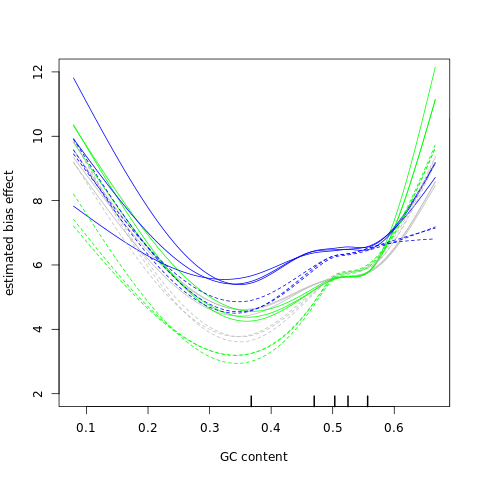

In [192]:
%%R
cqnplot <- function(x, n = 1, col = "grey60", ylab="estimated bias effect", 
                    xlab = "", type = "l", lty = 1, ...) {
    if(class(x) != "cqn")
        stop("'x' needs to be of class 'cqn'")
    if(n == 1) {
        func <- x$func1
        grid <- x$grid1
        knots <- x$knots1
    }
    if(n == 2) {
        if(is.null(x$func2))
            stop("argument 'x' does not appear to have two smooth functions (component 'func2' is NULL)")
        func <- x$func2
        grid <- x$grid2
        knots <- x$knots2
    }
    
    
    #par(mar=c(5.1, 4.1, 4.1, 8.1), xpd=TRUE)
    matplot(replicate(ncol(func), grid), func, ylab = ylab, xlab = xlab, type = type,
            col = col, lty = lty, ...)
    
    legend("bottomleft", legend = colnames(x$counts), inset=c(1,0),
           title="Samples", lty = lty, col = col)
    rug(knots, lwd = 2)
    invisible(x)
    
}


library(repr)
#options(repr.plot.width = 10, repr.plot.height = 0.75)
# Change plot size to 4 x 3
#options(repr.plot.width=4, repr.plot.height=3)


colors <- c(
    'grey','grey','grey',
    'green','green','green',
    'blue','blue','blue',
    'grey','grey','grey',
    'green','green','green',
    'blue','blue','blue'
           )
lty =c(1,1,1,1,1,1,1,1,1,
       2,2,2,2,2,2,2,2,2)

#png("Figures/Figure_12.png")
#par(mfrow=c(1,2))
cqnplot(cqn.subset, col=colors,
        n = 1, xlab = "GC content", lty = lty,
        ylim = c(2,12), 
        

       )
#dev.off()

#ggsave('plot.png', width=8.27, height= 11.69) #A4 size in inches
#dev.off()

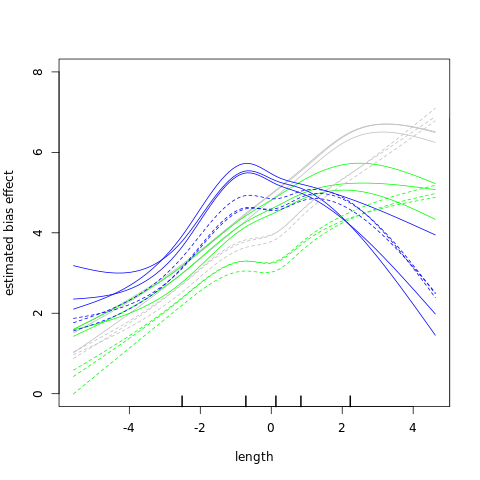

In [193]:
%%R
library(repr)
#options(repr.plot.width = 12, repr.plot.height = 0.75)
# Change plot size to 4 x 3
#options(repr.plot.width=8, repr.plot.height=3)


colors <- c(
    'grey','grey','grey',
    'green','green','green',
    'blue','blue','blue',
    'grey','grey','grey',
    'green','green','green',
    'blue','blue','blue'
           )
lty =c(1,1,1,1,1,1,1,1,1,
       2,2,2,2,2,2,2,2,2)

#par(mfrow=c(1,2))
#png("Figures/Figure_13.png")
cqnplot(cqn.subset, col=colors,
        n = 2, xlab = "length", lty = lty,
        ylim = c(0,8), 
    
       )
#dev.off()

### Bias Correction

In [194]:
%%R
RPKM.cqn <- cqn.subset$y + cqn.subset$offset
out_table <- RPKM.cqn
head(out_table)

               B_tot_1    B_tot_2    B_tot_3   B_pol_1     B_pol_2    B_pol_3
Tb927.8.130 -4.6680907 -4.7207119 -4.9391537 -4.431684 -4.25757999 -3.3826027
Tb927.8.230 -3.6794621 -6.3452853 -3.7651126 -3.425919 -1.58267207 -2.5899760
Tb927.8.480  1.3739711  2.8136104  2.5324458  1.408942  2.57774476  1.5856000
Tb927.8.490  1.2874862  1.5329011  2.0768877  1.729604  2.22916940  2.2330385
Tb927.8.500 -1.3648555 -0.6859749 -0.5077226 -1.042177 -0.71740825 -1.0421768
Tb927.8.510 -0.5688572 -0.3452519 -0.6557743 -1.193085 -0.03609472 -0.5966685
                B_sub_1    B_sub_2    B_sub_3   P_tot_1    P_tot_2     P_tot_3
Tb927.8.130 -1.36485550 -1.8068361 -0.6557743 -1.912770  0.4415895 -0.05254723
Tb927.8.230 -0.05254723 -0.2287825  0.3361460 -1.507144 -0.5688572 -0.45062103
Tb927.8.480  1.22032232  2.0520401  0.9409153  1.120503  1.5592297  1.46012105
Tb927.8.490  2.91031689  3.2772362  3.7404154  2.616609  2.6459959  2.83463362
Tb927.8.500  2.93532259  3.3847529  3.7733676  1.590618  1.

In [195]:
#out_table

In [196]:
%R -o out_table
out_table = pd.DataFrame(out_table,index=indata.index.values,columns=indata.columns)
out_table.head()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb927.8.130,-4.668091,-4.720712,-4.939154,-4.431684,-4.257580,-3.382603,-1.364856,-1.806836,-0.655774,-1.912770,0.441590,-0.052547,-0.052547,-0.036095,-0.052547,0.581835,0.281312,-0.871338
Tb927.8.230,-3.679462,-6.345285,-3.765113,-3.425919,-1.582672,-2.589976,-0.052547,-0.228783,0.336146,-1.507144,-0.568857,-0.450621,0.309560,0.072751,0.867092,-0.999599,-1.135486,-3.034467
Tb927.8.480,1.373971,2.813610,2.532446,1.408942,2.577745,1.585600,1.220322,2.052040,0.940915,1.120503,1.559230,1.460121,1.259683,1.084869,1.246485,2.666962,2.373621,1.889580
Tb927.8.490,1.287486,1.532901,2.076888,1.729604,2.229169,2.233038,2.910317,3.277236,3.740415,2.616609,2.645996,2.834634,3.514372,3.261627,3.464960,3.070292,3.074183,3.207156
Tb927.8.500,-1.364856,-0.685975,-0.507723,-1.042177,-0.717408,-1.042177,2.935323,3.384753,3.773368,1.590618,1.863897,1.778706,1.745003,1.324989,1.330786,2.543875,2.756850,2.575067


### Visualise Normalized Counts

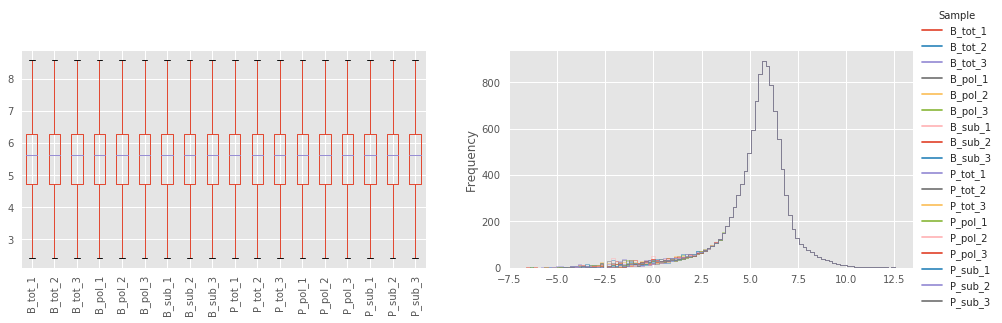

(11500, 18)


In [197]:
fig,axes=plt.subplots(figsize=(16,4),ncols=2)
ax = axes[0]
out_table.plot(kind='box',ax=ax,rot=90,showfliers=False)

ax = axes[1]
out_table.replace(-np.inf,-1.5).plot(kind='hist',
                                            histtype='step',
                                            bins=100,ax=ax)
UT.hist_legend(ax,'Sample')
#ax.set_xticklabels(out_df.columns, rotation=90, )
plt.show()
print(out_table.shape)

## Differential Expression Analysis

In [198]:
#out_table.loc['mainVSG-427-2']

In [199]:
#[n for n in out_table.index.values if 'KS' in n]

In [200]:
%%R
library(edgeR)
# Make groups
design_with_all <- model.matrix( ~0+group )

y <- DGEList(counts=indata, 
                  lib.size = sizeFactors,
                  group = group, 
                  )

y$offset <- cqn.subset$glm.offset
# Estimate dispersion
y <- estimateGLMCommonDisp( y, design_with_all )
y <- estimateGLMTrendedDisp( y, design_with_all )
y <- estimateGLMTagwiseDisp( y, design_with_all )
# Fit counts to model
fit_all <- glmFit( y, design_with_all )
contrast_Bpol_v_Bsub <- glmLRT( fit_all, contrast=makeContrasts( groupBpol-groupBsub,
                                                                levels=design_with_all ) )

table_Bpol_v_Bsub <- topTags(contrast_Bpol_v_Bsub, n=Inf, 
                             sort.by = "none", adjust.method="BH")$table
topTags( contrast_Bpol_v_Bsub, n=5 )
head(table_Bpol_v_Bsub)

                 logFC    logCPM         LR       PValue          FDR
Tb927.8.130 -2.9564862 -1.561241  22.053714 2.651262e-06 4.373764e-06
Tb927.8.230 -2.6251594 -2.051878  20.957791 4.695146e-06 7.613392e-06
Tb927.8.480  0.4719124  2.235489   1.703419 1.918414e-01 2.160799e-01
Tb927.8.490 -1.2760907  2.340183  29.398170 5.893325e-08 1.063777e-07
Tb927.8.500 -4.3960395  1.660074 213.348526 2.554696e-48 1.854735e-47
Tb927.8.510 -2.7652946  1.582866  71.013430 3.548014e-17 9.497710e-17


In [201]:
%%R
contrast_Ppol_v_Psub <- glmLRT( fit_all, contrast=makeContrasts(groupPpol-groupPsub,
                                                                levels=design_with_all ) )

table_Ppol_v_Psub <- topTags(contrast_Ppol_v_Psub, n=Inf, sort.by = "none", adjust.method="BH")$table
topTags( contrast_Ppol_v_Psub, n=5 )

Coefficient:  1*groupPpol -1*groupPsub 
                   logFC   logCPM       LR        PValue           FDR
KS17gene_2065a -3.680019 7.081998 1975.705  0.000000e+00  0.000000e+00
KS17gene_4635a -2.899841 6.980378 1467.013 5.760805e-321 3.312463e-317
Tb11.v5.0669    2.891069 6.792358 1430.263 5.574378e-313 2.136845e-309
KS17gene_4624a -2.731692 6.161727 1417.265 3.721148e-310 1.069830e-306
Tb927.9.12030  -2.707428 6.682712 1329.430 4.546559e-291 1.045709e-287


In [202]:
!mkdir -p Tables

In [203]:
%R -o table_Ppol_v_Psub
table_Ppol_v_Psub['log_PValue'] = -np.log10(table_Ppol_v_Psub['PValue'])
table_Ppol_v_Psub['log_FDR'] = -np.log10(table_Ppol_v_Psub['FDR'])
table_Ppol_v_Psub['desc']=[desc_dict.get(n,'none') for n in table_Ppol_v_Psub.index.values]
table_Ppol_v_Psub.to_csv('Tables/Table_5.csv')
table_Ppol_v_Psub.head()

,logFC,logCPM,LR,PValue,FDR,log_PValue,log_FDR,desc
Tb927.8.130,-0.312192,-1.561241,0.217095,0.641262,0.673780,0.192964,0.171482,variant surface glycoprotein (VSG atypical) ...
Tb927.8.230,5.939475,-2.051878,3.286062,0.069870,0.085808,1.155707,1.066470,expression site-associated gene 3 (ESAG3) deg...
Tb927.8.480,-1.254501,2.235489,8.492324,0.003566,0.005049,2.447760,2.296779,phosphatidic acid phosphatase protein putative
Tb927.8.490,0.271180,2.340183,1.090685,0.296320,0.332262,0.528240,0.478519,hypothetical protein
Tb927.8.500,-1.437266,1.660074,11.155598,0.000838,0.001256,3.076868,2.900965,hypothetical protein


In [204]:
%R -o table_Bpol_v_Bsub
table_Bpol_v_Bsub.head()
table_Bpol_v_Bsub['log_PValue'] = -np.log10(table_Bpol_v_Bsub['PValue'])
table_Bpol_v_Bsub['log_FDR'] = -np.log10(table_Bpol_v_Bsub['FDR'])

In [205]:
table_Bpol_v_Bsub['desc']=[desc_dict.get(n,'none') for n in table_Bpol_v_Bsub.index.values]
table_Bpol_v_Bsub.head()

,logFC,logCPM,LR,PValue,FDR,log_PValue,log_FDR,desc
Tb927.8.130,-2.956486,-1.561241,22.053714,2.651262e-06,4.373764e-06,5.576547,5.359145,variant surface glycoprotein (VSG atypical) ...
Tb927.8.230,-2.625159,-2.051878,20.957791,4.695146e-06,7.613392e-06,5.328351,5.118422,expression site-associated gene 3 (ESAG3) deg...
Tb927.8.480,0.471912,2.235489,1.703419,1.918414e-01,2.160799e-01,0.717058,0.665386,phosphatidic acid phosphatase protein putative
Tb927.8.490,-1.276091,2.340183,29.398170,5.893325e-08,1.063777e-07,7.229640,6.973149,hypothetical protein
Tb927.8.500,-4.396040,1.660074,213.348526,2.554696e-48,1.854735e-47,47.592661,46.731718,hypothetical protein


In [206]:
table_Bpol_v_Bsub.to_csv('Tables/Table_4.csv')

### Grumpy

In [207]:
ks_lncRNA = open('../polisome/InData/GS_gene_list.txt').read().split('\n')
def grampy_VolcanoPlot(table,title,ax=False,ksgene='KS17gene_3137a',xlims=False):
    plt.style.use('ggplot')
    if not ax:
        fig,ax=plt.subplots(figsize=(12,6))
    ax.set_title(title)
    
    table.plot(x='logFC',y='log_FDR',kind='scatter',s=5,alpha=0.2,ax=ax,c='black',label='the rest')
    
    temp = [n for n in ks_lncRNA if n in table.index.values]
    table.loc[temp].plot(x='logFC',y='log_FDR',kind='scatter',s=10,alpha=1,c='b',ax=ax,
                              label='lncRNA')
    
    
    table.loc[[ksgene]].plot(y='log_FDR',x='logFC',kind='scatter',ax=ax,s=50, alpha=1
                                                   ,c='r',label='Grumpy')
    
    lgnd= ax.legend()
    lgnd.legendHandles[0]._sizes = [20]
    lgnd.legendHandles[1]._sizes = [20]
    lgnd.legendHandles[2]._sizes = [20]
    if xlims:
        ax.set_xlim(xlims[0],xlims[1])

def grampy_MAplot(table,title,ksgene='KS17gene_3137a'):
    plt.style.use('ggplot')
    fig,ax=plt.subplots(figsize=(12,6))
    ax.set_title(title)
    table.plot(x='logCPM',y='logFC',kind='scatter',s=5,alpha=0.2,ax=ax,c='black',label='the rest')
    temp = [n for n in ks_lncRNA if n in table.index.values]
    table.loc[temp].plot(x='logCPM',y='logFC',kind='scatter',s=10,alpha=1,c='b',ax=ax,
                             label='lncRNA')
    table.loc[[ksgene]].plot(y='logFC',x='logCPM',kind='scatter',ax=ax,s=50, alpha=1
                                                   ,c='r',label='Grumpy')
    lgnd= ax.legend()
    for i,n in enumerate(lgnd.legendHandles):
        n._sizes = [20]

In [208]:
!mkdir -p Figures

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


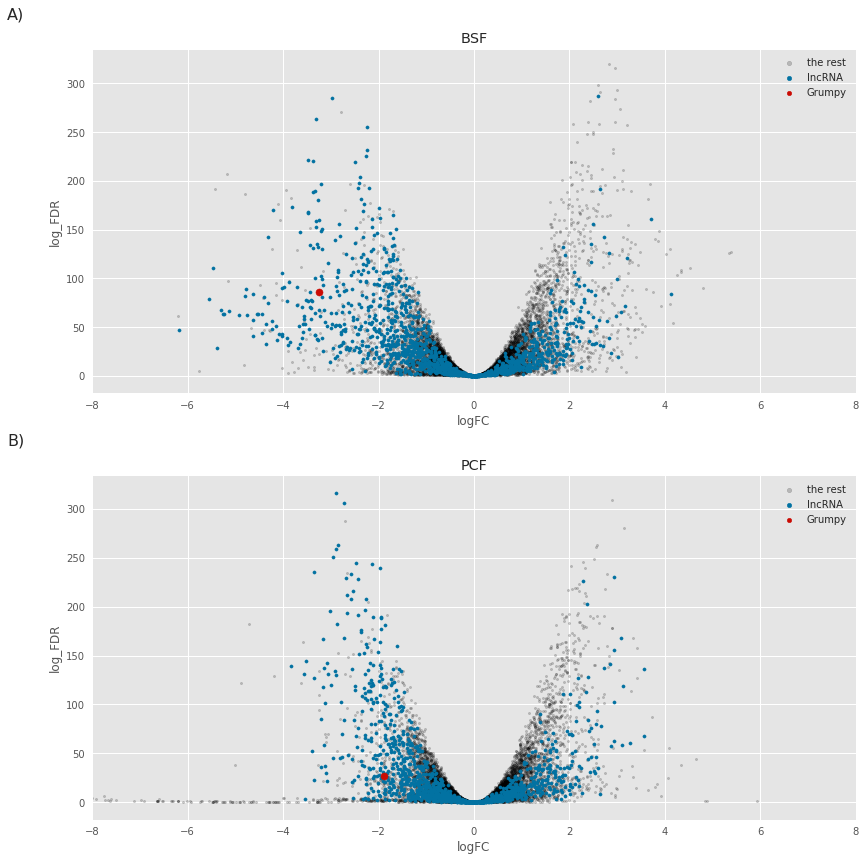

In [209]:
fig,axes=plt.subplots(figsize=(12,12),nrows=2)
grampy_VolcanoPlot(table_Bpol_v_Bsub,'BSF',axes[0],xlims=(-8,8))
grampy_VolcanoPlot(table_Ppol_v_Psub,'PCF',axes[1],xlims=(-8,8))
UT.set_fig_label(axes[0],'A')
UT.set_fig_label(axes[1],'B')
plt.tight_layout()
plt.savefig('Figures/Figure_13.png')

### average subpolysome/polysome

In [210]:
%%R
contrast_pol_v_sub <- glmLRT( fit_all, contrast=makeContrasts((groupPpol+groupBpol)/2-(groupPsub+groupBsub)/2,
                                                                levels=design_with_all ) )

table_pol_v_sub <- topTags(contrast_pol_v_sub, n=Inf, sort.by = "none", adjust.method="BH")$table
topTags( contrast_pol_v_sub, n=20 )
#head(contrast_pol_v_sub)

Coefficient:  0.5*groupBpol -0.5*groupBsub 0.5*groupPpol -0.5*groupPsub 
                   logFC   logCPM       LR PValue FDR
Tb927.8.6036   -4.760889 9.288940 1703.867      0   0
Tb927.11.6565  -3.705789 4.887900 1598.123      0   0
Tb927.11.6860   3.503547 6.208457 1680.818      0   0
KS17gene_2065a -3.419630 7.081998 3602.498      0   0
Tb927.11.6870   3.380150 6.868185 2845.083      0   0
KS17gene_34a   -3.252296 7.055789 1488.981      0   0
KS17gene_4596a -3.205888 7.320085 1521.411      0   0
KS17gene_4606a -3.187814 7.763983 1677.422      0   0
Tb11.v5.0669    3.160771 6.792358 3418.931      0   0
KS17gene_2098a -3.097077 6.538413 2042.711      0   0
KS17gene_7119a -3.043340 5.622751 1794.828      0   0
Tb927.11.14950  2.965084 7.578183 2057.993      0   0
Tb927.11.9530   2.948541 7.892071 1653.473      0   0
Tb927.7.1470    2.918193 7.285244 3019.921      0   0
KS17gene_3178a -2.911431 6.506035 2789.993      0   0
Tb11.v5.0360    2.889828 6.508159 2864.606      0   0
Tb927.11.

In [211]:
%R -o table_pol_v_sub
table_pol_v_sub.head()
table_pol_v_sub['log_PValue'] = -np.log10(table_pol_v_sub['PValue'])
table_pol_v_sub['log_FDR'] = -np.log10(table_pol_v_sub['FDR'])


In [212]:
#table_pol_v_sub.loc['KS17gene_1749a']

## ANOVA Like

In [213]:
%%R
design_anova <- model.matrix(~group, data=y$samples)
fit <- glmQLFit(y, design_anova)
qlf <- glmQLFTest(fit, coef=2:6)
anova_like <- topTags(qlf, n=Inf, sort.by = "none", adjust.method="BH")$table
head(anova_like)

            logFC.groupBsub logFC.groupBtot logFC.groupPpol logFC.groupPsub
Tb927.8.130       2.9477602     -0.63484811       3.7896779       4.0799602
Tb927.8.230       2.6261131     -1.73404475       1.1637889      -4.7764569
Tb927.8.480      -0.4707066      0.40762085      -0.8695015       0.3793051
Tb927.8.490       1.2760758     -0.41023603       1.3140268       1.0429474
Tb927.8.500       4.3961461      0.16851038       2.1731829       3.6103065
Tb927.8.510       2.7643092      0.04594391       3.8458703       3.9337853
            logFC.groupPtot    logCPM          F       PValue          FDR
Tb927.8.130       3.4790019 -1.561241  21.760504 9.539574e-07 1.133317e-06
Tb927.8.230      -0.3862012 -2.051878  12.732190 6.874680e-05 7.344061e-05
Tb927.8.480      -0.6453757  2.235489   3.063603 3.844324e-02 3.870577e-02
Tb927.8.490       0.6041552  2.340183  18.705194 2.723369e-06 3.134068e-06
Tb927.8.500       2.6515978  1.660074 108.424223 4.614112e-12 1.362668e-11
Tb927.8.510       

In [214]:
%R -o anova_like
anova_like=anova_like[['F', 'PValue', 'FDR']]
anova_threshold = 1e-2
anova_like.shape,anova_like[anova_like['FDR']<anova_threshold].shape

((11500, 3), (11343, 3))

In [215]:
out_table.shape

(11500, 18)

In [216]:
#%%R
#library(HybridMTest)
#computed but not used for now
#anova_test <- row.oneway.anova(cpm_df, group)
#FDR1 <- p.adjust(anova_test$pval, "bonferroni")

In [217]:
#%R -o cpm_df,anova_test,FDR1,tt_Bsub_Bpol

In [218]:
#%R length(FDR1[FDR1 < 0.01])

In [219]:
out_df = out_table.copy()

In [220]:
out_df.head()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
Tb927.8.130,-4.668091,-4.720712,-4.939154,-4.431684,-4.257580,-3.382603,-1.364856,-1.806836,-0.655774,-1.912770,0.441590,-0.052547,-0.052547,-0.036095,-0.052547,0.581835,0.281312,-0.871338
Tb927.8.230,-3.679462,-6.345285,-3.765113,-3.425919,-1.582672,-2.589976,-0.052547,-0.228783,0.336146,-1.507144,-0.568857,-0.450621,0.309560,0.072751,0.867092,-0.999599,-1.135486,-3.034467
Tb927.8.480,1.373971,2.813610,2.532446,1.408942,2.577745,1.585600,1.220322,2.052040,0.940915,1.120503,1.559230,1.460121,1.259683,1.084869,1.246485,2.666962,2.373621,1.889580
Tb927.8.490,1.287486,1.532901,2.076888,1.729604,2.229169,2.233038,2.910317,3.277236,3.740415,2.616609,2.645996,2.834634,3.514372,3.261627,3.464960,3.070292,3.074183,3.207156
Tb927.8.500,-1.364856,-0.685975,-0.507723,-1.042177,-0.717408,-1.042177,2.935323,3.384753,3.773368,1.590618,1.863897,1.778706,1.745003,1.324989,1.330786,2.543875,2.756850,2.575067


## RadViz - Signature in BSF SUB

In [221]:
#https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

#from cqn These values are on the log2scale.        
radviz_dataset = np.exp(out_df).copy()

radviz_dataset=radviz_dataset[anova_like['FDR']<anova_threshold]
cols = list(radviz_dataset.columns)
#group coluns in cunk of 3 to compute the mean
col_grups = chunks(cols, 3)
for g in col_grups:
    base = '_'.join(g[0].split('_')[0:2])
    radviz_dataset[base]=radviz_dataset[g].median(axis=1)

#assign each gene to the class with max count

classes = radviz_dataset.iloc[:,18:].idxmax(axis=1)
#replace = {'B_pol':0, 'B_sub':1, 'B_tot':2, 'P_pol':3, 'P_sub':4, 'P_tot':5}
#classes = classes.replace(replace)
radviz_dataset=radviz_dataset.iloc[:,18:]
radviz_dataset['classes']=classes
radviz_dataset.head()

,B_tot,B_pol,B_sub,P_tot,P_pol,P_sub,classes
Tb927.8.130,0.008909,0.014157,0.255418,0.948810,0.948810,1.324867,P_sub
Tb927.8.230,0.023165,0.075022,0.948810,0.566172,1.362825,0.321266,P_pol
Tb927.8.490,4.631594,9.292145,26.502425,14.097477,31.975177,21.632207,P_pol
Tb927.8.500,0.503599,0.352686,29.510701,5.922187,3.784015,13.132198,B_sub
Tb927.8.510,0.566172,0.550643,6.785735,16.347881,26.987912,26.139965,P_pol


In [222]:
radviz_dataset.shape

(11343, 7)

In [223]:
UT.radviz??

### RadViz figure

P_tot
B_sub
B_tot
P_pol
B_pol
P_sub
['B_tot', 'P_tot', 'B_sub', 'P_sub', 'B_pol', 'P_pol']


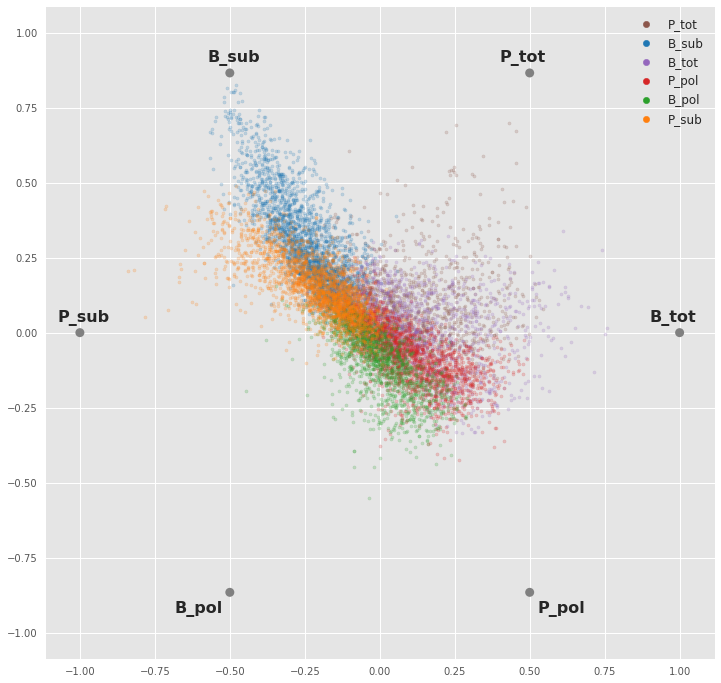

In [225]:
fig,ax=plt.subplots(figsize=(12,12))
cols = [n for n in out_df.columns if n.endswith('_mean')]
color = {'B_tot':'tab:purple','B_pol':'tab:green','B_sub':'tab:blue',
         'P_tot':'tab:brown','P_pol':'tab:red','P_sub':'tab:orange'}

radviz_dataset=radviz_dataset[['B_tot','P_tot','B_sub','P_sub','B_pol','P_pol','classes']]
rad_viz,to_plot,s = UT.radviz(radviz_dataset, 
                           'classes', color=color, ax=ax,)


plt.savefig('Figures/Figure_8.png')

## Cluster analysis

In [62]:
#mydata = out_df.iloc[:,:18]
#min_values = []
#for col in mydata:
#    min_values.append(mydata[col][mydata[col]>0].min())
#min_values
#del mydata


cluster_dataset=np.exp(out_df.iloc[:,:18])#+min_values
cluster_dataset.head()
cluster_dataset.describe()

,B_tot_1,B_tot_2,B_tot_3,B_pol_1,B_pol_2,B_pol_3,B_sub_1,B_sub_2,B_sub_3,P_tot_1,P_tot_2,P_tot_3,P_pol_1,P_pol_2,P_pol_3,P_sub_1,P_sub_2,P_sub_3
count,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000
mean,784.689998,784.689615,784.690967,784.694236,784.692470,784.694784,784.745404,784.746369,784.773109,784.722325,784.764924,784.766785,784.791597,784.770290,784.774646,784.760420,784.760646,784.715872
std,4577.615774,4577.615880,4577.615758,4577.615028,4577.615324,4577.614959,4577.606524,4577.606373,4577.602131,4577.610323,4577.603053,4577.602877,4577.598746,4577.602266,4577.601527,4577.603830,4577.603872,4577.611449
min,0.001373,0.001778,0.003487,0.003589,0.004205,0.001668,0.006305,0.015353,0.009318,0.005695,0.038656,0.043798,0.039582,0.040059,0.040598,0.025629,0.019838,0.009616
25%,113.519037,113.519037,113.569233,113.519037,113.519037,113.519037,113.569233,113.569233,113.569233,113.519037,113.519037,113.519037,113.569233,113.519037,113.519037,113.519037,113.569233,113.519037
50%,276.068145,276.068145,276.068145,276.068145,276.068145,276.068145,276.068145,276.068145,276.068145,276.068145,276.068145,276.068145,276.068145,276.068145,276.068145,276.068145,276.068145,276.068145
75%,532.156669,532.156669,532.156669,532.156669,532.156669,532.156669,532.156669,532.156669,532.156669,532.156669,532.156669,532.156669,532.156669,532.156669,532.156669,532.156669,532.156669,532.156669
max,286089.839359,286089.839359,286089.839359,286089.839359,286089.839359,286089.839359,286089.839359,286089.839359,286089.839359,286089.839359,286089.839359,286089.839359,286089.839359,286089.839359,286089.839359,286089.839359,286089.839359,286089.839359


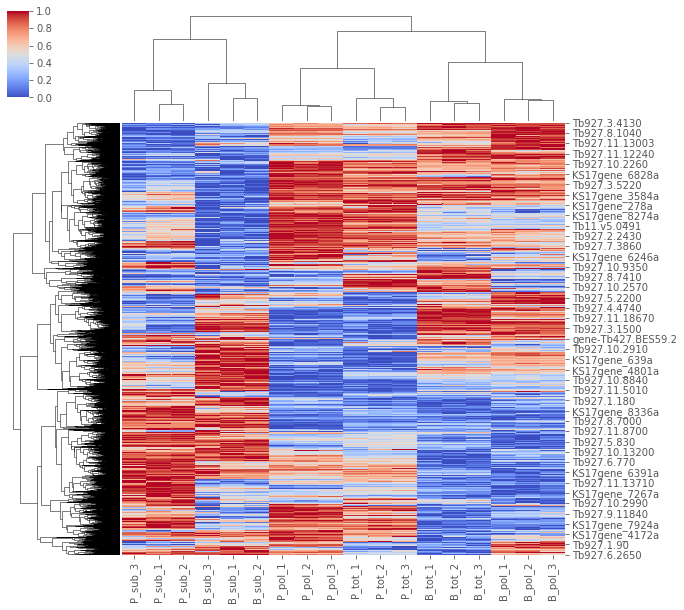

In [63]:
#%R -o anova_test,FDR
cluster_dataset=out_df.iloc[:,:18]
clustergrid = sns.clustermap(cluster_dataset[anova_like['FDR']<anova_threshold].sample(frac=0.3),
                             cmap=sns.color_palette("coolwarm", 256), 
                             standard_scale=0)


### Number of clusters

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


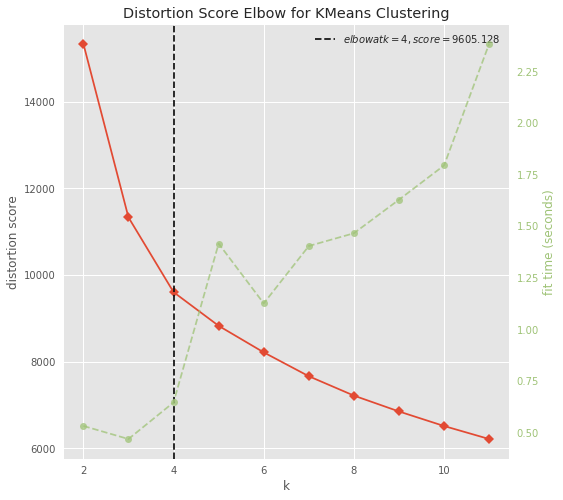

In [64]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
plt.style.use('ggplot')
X = UT.standard_scale(cluster_dataset[anova_like['FDR']<anova_threshold],0)
# Instantiate the clustering model and visualizer
model = KMeans()
fig, ax = plt.subplots(figsize=(8,8)) 
visualizer = KElbowVisualizer(model, k=(2,12),ax=ax)

visualizer.fit(X.values)        # Fit the data to the visualizer


visualizer.show(outpath="Figures/Figure_9.png")
#visualizer.show()


In [65]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
pd.Series(kmeans.labels_).value_counts()

0    3336
1    2874
2    2646
3    2487
dtype: int64

In [66]:
#from sklearn.cluster import SpectralBiclustering

#clustering = SpectralBiclustering(n_clusters=5,
#assign_labels="discretize",
#random_state=0).fit(X)
#pd.Series(clustering.labels_).value_counts()

### Cluster figure

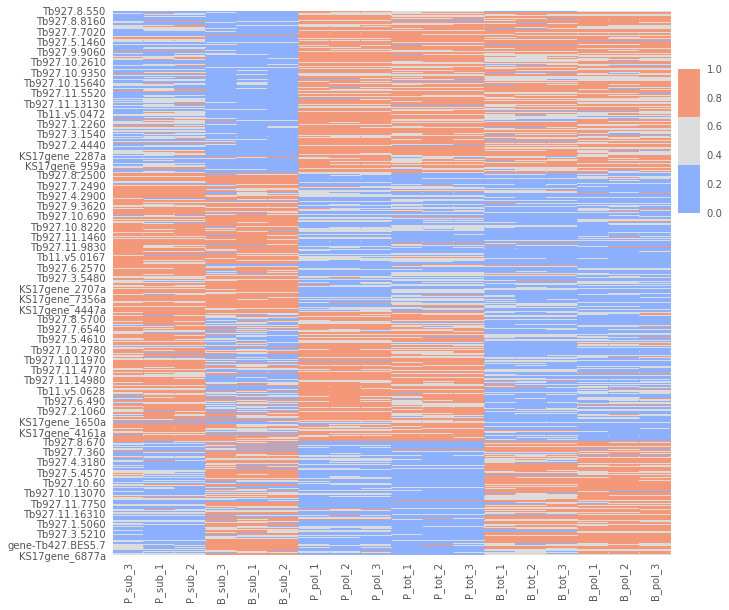

In [67]:
#res = TDdf[anova_test['FDR']<0.01]
X['label']=kmeans.labels_+1
#X['label']=X['label'].replace(dict_replace)
order = pd.Series(kmeans.labels_).value_counts().index.values

list_df = []
for n in order:
    list_df.append(X[X['label']==n+1])

final_list_df = []
for index,temp_df in enumerate(list_df):
    temp_df['label']=index+1
    final_list_df.append(temp_df)
    

X = pd.concat(final_list_df)


fig, ax = plt.subplots(figsize=(10,10))  
cbar_ax = fig.add_axes([.91, .6, .03, .2])
# Sample figsize in inches




sns.heatmap(X.iloc[:,0:-1].T.iloc[
    clustergrid.dendrogram_col.reordered_ind].T.astype(float),
            cmap=sns.color_palette("coolwarm", 3),
           ax=ax, cbar_ax = cbar_ax, cbar=True)

plt.savefig('Figures/Figure_10.png')

In [68]:
ks_lncRNA = open('../polisome/InData/GS_gene_list.txt').read().split('\n')
X['is_ks']=[1 if n in ks_lncRNA else 0 for n in X.index.values]
len(ks_lncRNA)
X['is_ks'].value_counts()

0    9923
1    1420
Name: is_ks, dtype: int64

### Table lncRNA enrichment in clusters 


In [69]:
from scipy import stats


#k = np.arange(5)
#N = 52 # population size
#G = 4  # number of good elements in population
#n = 5  # simple random sample size
#stats.hypergeom.pmf(k, N, G, n)

population_size = X.shape[0]

for n in [1,2,3,4]:
    sample_size = X[X['label']==n].shape[0]
    sample_sucess = X[(X['label']==n) & (X['is_ks']==1) ].shape[0]
    population_sucess = X[X['is_ks']==1].shape[0]
    #print(n, sample_sucess, sample_size, population_sucess, population_size)
    print('cluster {n}: enrichment pvalue={pval:.2e}'.format(n=n, pval =stats.hypergeom.pmf(sample_sucess, 
                                 population_size, 
                                 population_sucess, 
                                 sample_size)))
        
    #avg_value = cluster_dataset.loc[X[(X['label']==n)].index.values][
    #    ['BSF-PCF-1','BSF-PCF-2','BSF-PCF-3']].median(axis=1).median()
    #print(np.log2(avg_value))
    print('_________')

cluster 1: enrichment pvalue=2.78e-05
_________
cluster 2: enrichment pvalue=2.07e-15
_________
cluster 3: enrichment pvalue=1.44e-07
_________
cluster 4: enrichment pvalue=3.84e-24
_________


### Cluster Table

In [70]:
X['desc']=[desc_dict.get(n,'none') for n in X.index.values]
X['H/ACA-like snoRNA']=[1 if 'H/ACA-like snoRNA' in n else 0 for n in X['desc']]
X['snoRNA']=[1 if 'snoRNA' in n else 0 for n in X.index.values]
X['Noncoding']=[1 if 'Noncoding RNA' in n else 0 for n in X['desc']]

### Table snoRNA

In [71]:
X.groupby('label')['snoRNA','H/ACA-like snoRNA','is_ks'].sum()

,snoRNA,H/ACA-like snoRNA,is_ks
label,,,
1,0,0,359
2,0,0,482
3,0,0,406
4,0,0,173


In [72]:
X.to_csv('Tables/Table_1.csv')

In [73]:
for n in [1,2,3,4]:
    sample_size = X[X['label']==n].shape[0]
    sample_sucess = X[(X['label']==n) & (X['H/ACA-like snoRNA']==1) ].shape[0]
    population_sucess = X[X['H/ACA-like snoRNA']==1].shape[0]
    #print(n, sample_sucess, sample_size, population_sucess, population_size)
    print('cluster {n}: enrichment pvalue={pval:.2e}'.format(n=n, pval =stats.hypergeom.pmf(sample_sucess, 
                                 population_size, 
                                 population_sucess, 
                                 sample_size)))
        
    #avg_value = cluster_dataset.loc[X[(X['label']==n)].index.values][
    #    ['BSF-PCF-1','BSF-PCF-2','BSF-PCF-3']].median(axis=1).median()
    #print(np.log2(avg_value))
    print('_________')

cluster 1: enrichment pvalue=1.00e+00
_________
cluster 2: enrichment pvalue=1.00e+00
_________
cluster 3: enrichment pvalue=1.00e+00
_________
cluster 4: enrichment pvalue=1.00e+00
_________


In [74]:
for n in [1,2,3,4]:
    sample_size = X[X['label']==n].shape[0]
    sample_sucess = X[(X['label']==n) & (X['snoRNA']==1) ].shape[0]
    population_sucess = X[X['snoRNA']==1].shape[0]
    #print(n, sample_sucess, sample_size, population_sucess, population_size)
    print('cluster {n}: enrichment pvalue={pval:.2e}'.format(n=n, pval =stats.hypergeom.pmf(sample_sucess, 
                                 population_size, 
                                 population_sucess, 
                                 sample_size)))
        
    #avg_value = cluster_dataset.loc[X[(X['label']==n)].index.values][
    #    ['BSF-PCF-1','BSF-PCF-2','BSF-PCF-3']].median(axis=1).median()
    #print(np.log2(avg_value))
    print('_________')

cluster 1: enrichment pvalue=1.00e+00
_________
cluster 2: enrichment pvalue=1.00e+00
_________
cluster 3: enrichment pvalue=1.00e+00
_________
cluster 4: enrichment pvalue=1.00e+00
_________


In [75]:
for n in [1,2,3,4]:
    sample_size = X[X['label']==n].shape[0]
    sample_sucess = X[(X['label']==n) & (X['Noncoding']==1) ].shape[0]
    population_sucess = X[X['Noncoding']==1].shape[0]
    #print(n, sample_sucess, sample_size, population_sucess, population_size)
    print('cluster {n}: enrichment pvalue={pval:.2e}'.format(n=n, pval =stats.hypergeom.pmf(sample_sucess, 
                                 population_size, 
                                 population_sucess, 
                                 sample_size)))
        
    #avg_value = cluster_dataset.loc[X[(X['label']==n)].index.values][
    #    ['BSF-PCF-1','BSF-PCF-2','BSF-PCF-3']].median(axis=1).median()
    #print(np.log2(avg_value))
    print('_________')

cluster 1: enrichment pvalue=1.00e+00
_________
cluster 2: enrichment pvalue=1.00e+00
_________
cluster 3: enrichment pvalue=1.00e+00
_________
cluster 4: enrichment pvalue=1.00e+00
_________


## GO term Analysis

In [76]:
from goatools.base import download_go_basic_obo
from goatools.associations import read_associations
from goatools.go_enrichment import GOEnrichmentStudy
from goatools.obo_parser import GODag
from goatools.associations import read_gaf

### Fix gaf file

In [77]:
import tqdm
replace_dict = {'P':'BP','F':'MF','C':'CC'}
def pars_trytripDB_gaf(infile):
    new_file = open(infile.replace('.gaf','2.gaf'),'w')
    for l in tqdm.tqdm(open(infile)):
        if l.startswith('!'):
            #new_file.write(l)
            continue
        else:    
            temp_list = l.split('\t')
            code = l.split('\t')[8]
            if code not in  replace_dict:
                continue
            temp_list[8] = replace_dict[code]
            new_file.write(temp_list[1]+'\t'+temp_list[4]+'\n')
    new_file.close()

#pars_trytripDB_gaf('InData/TriTrypDB-46_TbruceiTREU927_GO.gaf')    

In [78]:
obo_fname = download_go_basic_obo()
in_go=os.path.join('../polisome/InData/go-basic.obo')
obodag = GODag(in_go)
geneid2gos = read_associations('../polisome/InData/TriTrypDB-46_TbruceiTREU927_GO2.gaf')

  EXISTS: go-basic.obo
../polisome/InData/go-basic.obo: fmt(1.2) rel(2020-06-01) 47,233 GO Terms
HMS:0:00:00.105812  26,294 annotations READ: ../polisome/InData/TriTrypDB-46_TbruceiTREU927_GO2.gaf 
**ERROR IdToGosReader(..., godag=None).get_id2gos: GODAG is None. IGNORING namespace(BP)

7683 IDs in all associations

In [79]:
out_df.shape,X.shape

((11500, 18), (11343, 24))

In [80]:
all_genes = out_df.index.values
print(len(all_genes))
goeaobj = GOEnrichmentStudy(
            list(all_genes), # List of mouse protein-coding genes
            geneid2gos, # geneid/GO associations
            obodag, # Ontologies
            propagate_counts = False,
            alpha = 0.05, # default significance cut-off
            methods = ['fdr_bh'])

11500

Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 64%  7,315 of 11,500 population items found in association


In [81]:
all_res = []
def analysis(data, cluster_id=0):
    geneids_study =  list(data[(data['label']==cluster_id)].index.values)
    geneids_study = [n for n in geneids_study if n in all_genes]
    goea_results_all = goeaobj.run_study(geneids_study)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.01]
    for item in goea_results_sig:
        item_list = str(item).split('\t')
        #print(item_list)
        tempres = [str(cluster_id), item_list[0], str(item_list[6]), item_list[1], item_list[3], item_list[4]]
        all_res.append('\t'.join(tempres))

for n in [1,2,3,4]:
    print(n,'_________________')
    analysis(X, cluster_id=n)

print(len(all_res))    
go_term_res = open('InData/goterm_enrich.txt','w')
go_term_res.write('\n'.join(all_res))
go_term_res.close()

1 _________________

Run GOEA Gene Ontology Analysis: current study set of 3336 IDs ... 70%  2,338 of  3,336 study items found in association
100%  3,336 of  3,336 study items found in population(11500)
Calculating 1,946 uncorrected p-values using fisher_scipy_stats
   1,946 GO terms are associated with  7,315 of 11,500 population items
   1,221 GO terms are associated with  2,338 of  3,336 study items
  METHOD fdr_bh:
      84 GO terms found significant (< 0.05=alpha) ( 73 enriched +  11 purified): statsmodels fdr_bh
   1,959 study items associated with significant GO IDs (enriched)
     111 study items associated with significant GO IDs (purified)
2 _________________

Run GOEA Gene Ontology Analysis: current study set of 2874 IDs ... 61%  1,756 of  2,874 study items found in association
100%  2,874 of  2,874 study items found in population(11500)
Calculating 1,946 uncorrected p-values using fisher_scipy_stats
   1,946 GO terms are associated with  7,315 of 11,500 population items
   

In [82]:
#pd.read_csv??

In [83]:
go_terms = pd.read_csv('InData/goterm_enrich.txt', sep='\t', header=None)
go_terms.columns = ['clusterID','goID','pvalue','goType','goDesc','found']
go_terms['found']=[int(n.split('/')[0]) for n in go_terms['found']]
go_terms['clusterID'] = ['C'+str(n) for n in go_terms['clusterID']]
print(go_terms.shape)
go_terms = go_terms[go_terms['found']>=2]
print(go_terms.shape)
del go_terms['found']
go_terms.head()

(81, 6)
(79, 6)


,clusterID,goID,pvalue,goType,goDesc
0,C1,GO:0010608,2.080000e-13,BP,posttranscriptional regulation of gene expression
1,C1,GO:0051603,1.710000e-11,BP,proteolysis involved in cellular protein catab...
2,C1,GO:0008152,5.580000e-09,BP,metabolic process
3,C1,GO:0006511,7.310000e-08,BP,ubiquitin-dependent protein catabolic process
4,C1,GO:0005975,2.490000e-07,BP,carbohydrate metabolic process


In [84]:
go_terms['clusterID'].value_counts()

C1    54
C4    17
C2     6
C3     2
Name: clusterID, dtype: int64

In [85]:
unique_go = go_terms.goID.value_counts()[go_terms.goID.value_counts()<=3].index.values
go_terms = go_terms[go_terms.goID.isin(unique_go)]
go_terms.head()

,clusterID,goID,pvalue,goType,goDesc
0,C1,GO:0010608,2.080000e-13,BP,posttranscriptional regulation of gene expression
1,C1,GO:0051603,1.710000e-11,BP,proteolysis involved in cellular protein catab...
2,C1,GO:0008152,5.580000e-09,BP,metabolic process
3,C1,GO:0006511,7.310000e-08,BP,ubiquitin-dependent protein catabolic process
4,C1,GO:0005975,2.490000e-07,BP,carbohydrate metabolic process


In [86]:
go_terms['clusterID'].value_counts()

C1    54
C4    17
C2     6
C3     2
Name: clusterID, dtype: int64

In [87]:
go_terms = go_terms[go_terms['clusterID']!='C1']

In [88]:
#vizGo = pd.pivot_table(go_terms, index='goID',columns['clusterID'])#.reset_index()
vizGo = pd.pivot_table(go_terms, index='goDesc', columns=['clusterID'])
vizGo = -np.log10(vizGo)
vizGo=vizGo.fillna(0)
print(vizGo.head())
vizGo.columns = ['C2','C3','C4']
vizGo =vizGo.sort_values(['C2','C3','C4'])
vizGo.head()

                                             pvalue                    
clusterID                                        C2        C3        C4
goDesc                                                                 
BBSome                                     4.534617  0.000000  0.000000
S-adenosylmethionine biosynthetic process  0.000000  0.000000  5.991400
adenylate cyclase activity                 0.000000  0.000000  8.838632
antigenic variation                        0.000000  0.000000  5.072117
axoneme                                    0.000000  5.346787  0.000000


,C2,C3,C4
goDesc,,,
nucleus,0.0,0.0,4.159894
metabolic process,0.0,0.0,4.659556
kinetoplast,0.0,0.0,5.005243
antigenic variation,0.0,0.0,5.072117
intracellular signal transduction,0.0,0.0,5.146302


In [89]:
vizGo.tail()

,C2,C3,C4
goDesc,,,
galactosyltransferase activity,5.097453,0.0,0.000000
ciliary basal body,5.588380,0.0,0.000000
glycosome,6.420216,0.0,0.000000
integral component of membrane,6.571865,0.0,11.510042
mRNA binding,7.643974,0.0,6.341989


### GO term Figure

(21.5, 0.5)


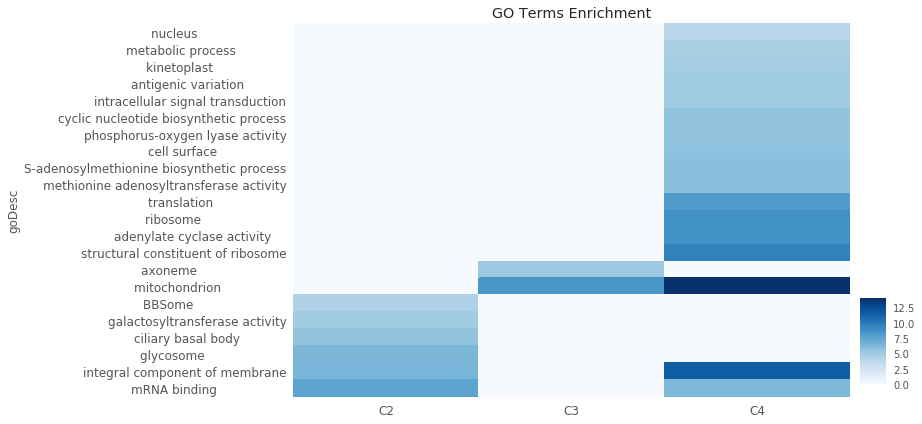

In [90]:
#del vizGo['C1']
fig, ax = plt.subplots(figsize=(12,6))  
cbar_ax = fig.add_axes([1, .1, .03, .2])
# Sample figsize in inches
sns.heatmap(vizGo,
            cmap=sns.color_palette("Blues", 128),
           ax=ax, cbar_ax = cbar_ax, cbar=True)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('GO Terms Enrichment')
print(ax.get_ylim())
ax.set_ylim(ax.get_ylim()[0]+0.5, 0)
plt.tight_layout()
plt.savefig('Figures/Figure_11.png')
plt.show()

## mRNA Half Life

In [91]:
pcf_hl = pd.read_csv('../polisome/InData/mRNA_Half_Life/mrnaPCFhl.txt',sep='\t',index_col=[0])
bsf_hl = pd.read_csv('../polisome/InData/mRNA_Half_Life/mrnaBSFhl.txt',sep='\t',index_col=[0])
hl = pcf_hl.join(bsf_hl,how='outer')
hl=hl.reset_index()
hl_lookup = pd.read_csv('../polisome/InData/mRNA_Half_Life//mRNAhl_lookup.txt',sep='\t',index_col=[0])
hl_df = hl_lookup.merge(hl,left_on='Input ID',right_on='Gene_ID',how='outer')
hl_df.set_index('Gene_ID',inplace=True)
hl_df=hl_df.join(X,how='left')
del hl_df['Unnamed: 6']
#hl_df['hl_dif']=hl_df['BSF_half-life']/hl_df['PCF_half-life']
hl_df.head()

,Organism,Genomic Location (Gene),Product Description,Gene Type,Input ID,PCF_half-life,BSF_half-life,B_tot_1,B_tot_2,B_tot_3,...,P_pol_3,P_sub_1,P_sub_2,P_sub_3,label,is_ks,desc,H/ACA-like snoRNA,snoRNA,Noncoding
Tb927.1.1020,T. brucei brucei TREU927,"Tb927_01_v5.1:294,104..296,172(+)",leucine-rich repeat-containing protein,protein coding,Tb927.1.1020,10.0,13.62,0.000000,0.081944,0.262397,...,0.964203,0.759845,0.717442,1.000000,3.0,0.0,leucine-rich repeat-containing protein,0.0,0.0,0.0
Tb927.1.1030,T. brucei brucei TREU927,"Tb927_01_v5.1:296,918..298,629(+)",Nucleolar protein 49,protein coding,Tb927.1.1030,10.0,7.91,0.000000,0.012317,0.057905,...,0.288026,0.600356,0.651276,0.699741,2.0,0.0,Nucleolar protein 49,0.0,0.0,0.0
Tb927.1.1040,NaN,NaN,NaN,NaN,NaN,NaN,6.05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tb927.1.1080,T. brucei brucei TREU927,"Tb927_01_v5.1:305,834..307,362(+)","TFIIH basal transcription factor subunit, puta...",protein coding,Tb927.1.1080,7.0,7.38,0.526023,0.358626,0.355136,...,0.133889,0.939893,0.901920,1.000000,2.0,0.0,TFIIH basal transcription factor subunit puta...,0.0,0.0,0.0
Tb927.1.1120,T. brucei brucei TREU927,"Tb927_01_v5.1:312,383..313,566(+)","ribosomal RNA-processing protein 8, putative",protein coding,Tb927.1.1120,10.0,8.97,0.149660,0.000000,0.108493,...,0.911532,0.704278,0.712601,0.658782,3.0,0.0,ribosomal RNA-processing protein 8 putative,0.0,0.0,0.0


In [92]:
#for col in ['PCF_half-life','BSF_half-life']:
#    col_zscore = col + '_zscore'
#    hl_df[col_zscore] =((hl_df[col] - hl_df[col].mean())/hl_df[col].std(ddof=0)).values

#hl_df['hl_dif_zscore']=hl_df['BSF_half-life_zscore']-hl_df['PCF_half-life_zscore']    
#hl_df.groupby('label')[['PCF_half-life_zscore','BSF_half-life_zscore','hl_dif_zscore']].mean()

### Table mRNA half life

In [93]:
hl_df['hl_dif']=hl_df['BSF_half-life']/hl_df['PCF_half-life']    
hl_df.groupby('label')[['PCF_half-life','BSF_half-life','hl_dif']].median().sort_values('hl_dif')

,PCF_half-life,BSF_half-life,hl_dif
label,,,
1.0,30.0,14.600,0.468688
3.0,20.0,10.915,0.505000
4.0,17.0,11.460,0.643831
2.0,15.0,10.470,0.651534


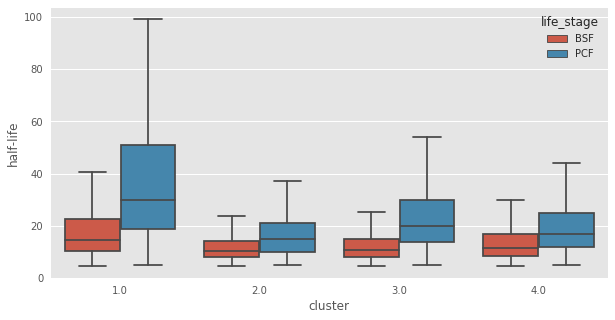

In [94]:
temp1 = hl_df[['BSF_half-life','label']]
temp1.columns = ['half-life','cluster']
temp1['life_stage']='BSF'
temp2 = hl_df[['PCF_half-life','label']]
temp2.columns = ['half-life','cluster']
temp2['life_stage']='PCF'
dataset_hl = pd.concat([temp1,temp2])

fig, ax = plt.subplots(figsize=(10,5))  
sns.boxplot(data=dataset_hl,x='cluster',
            y='half-life',hue='life_stage',
            showfliers=False,ax=ax)
plt.savefig('Figures/Figure_12.png')
plt.show()

In [95]:
dataset_hl.groupby(['cluster','life_stage'])['half-life'].mean().sort_values()

cluster  life_stage
2.0      BSF           12.207590
3.0      BSF           13.135885
4.0      BSF           14.402988
1.0      BSF           18.168259
2.0      PCF           18.249762
4.0      PCF           21.915452
3.0      PCF           25.561224
1.0      PCF           38.694915
Name: half-life, dtype: float64

## Find closest 5' to lncRNA

In [96]:
temp_cds = pd.read_csv('genomes/tb927_11/tb927_11.gtf',sep='\t',header=None)
temp_cds = temp_cds[temp_cds.iloc[:,2]=='CDS']
temp_cds.head()

,0,1,2,3,4,5,6,7,8
2,tryp_X-188b09.p2kB601,VEuPathDB,CDS,929,1489,.,+,0,"transcript_id ""Tb10.v4.0073:pseudogenic_transc..."
5,tryp_X-188b09.p2kB601,VEuPathDB,CDS,2775,3452,.,+,0,"transcript_id ""Tb10.v4.0074:pseudogenic_transc..."
8,tryp_X-188b09.p2kB601,VEuPathDB,CDS,3781,5223,.,+,0,"transcript_id ""Tb10.v4.0075:pseudogenic_transc..."
11,tryp_X-188b09.p2kB601,VEuPathDB,CDS,6264,7721,.,+,0,"transcript_id ""Tb10.v4.0076:pseudogenic_transc..."
14,tryp_X-188b09.p2kB601,VEuPathDB,CDS,9669,10955,.,+,0,"transcript_id ""Tb10.v4.0077:pseudogenic_transc..."


In [97]:
temp_cds.tail()

,0,1,2,3,4,5,6,7,8
40743,Tb927_11_v5.1,FGuegan,CDS,4848871,4851086,.,+,.,"transcript_id ""KS17gene_4350a:lncRNA""; gene_id..."
40745,Tb927_06_v5.1,FGuegan,CDS,1424502,1426539,.,+,.,"transcript_id ""KS17gene_1287a:lncRNA""; gene_id..."
40747,Tb927_08_v5.1,FGuegan,CDS,2478994,2479533,.,+,.,"transcript_id ""KS17gene_2175a:lncRNA""; gene_id..."
40749,Tb927_04_v5.1,FGuegan,CDS,1467317,1467499,.,-,.,"transcript_id ""KS17gene_4928a:lncRNA""; gene_id..."
40751,Tb927_07_v5.1,FGuegan,CDS,2171559,2173619,.,+,.,"transcript_id ""KS17gene_1626a:lncRNA""; gene_id..."


In [98]:
#temp_lnc = pd.read_csv('tb927_5.gtf',sep='\t',header=None)
#temp_lnc = temp_lnc[temp_lnc.iloc[:,-1].str.contains('lncRNA')]
#temp_lnc = temp_lnc[temp_lnc.iloc[:,2]=='transcript']
#temp_lnc.head()

In [99]:
chr_list = ['Tb927_0{}_v5.1'.format(n) for n in range(1,10)]
chr_list+= ['Tb927_1{}_v5.1'.format(n) for n in range(0,2)]

In [100]:
merge = temp_cds
merge.columns = ['Chro','Source','ttype','start','end','f1','orient','f2','desc']
#merge = merge.sort_values(['Chro','start'])
merge = merge[merge.Chro.isin(chr_list)]
merge.drop(['f1','f2'],axis=1,inplace=True)
merge.head()

,Chro,Source,ttype,start,end,orient,desc
37,Tb927_08_v5.1,VEuPathDB,CDS,2,1327,+,"transcript_id ""Tb927.8.100:pseudogenic_transcr..."
40,Tb927_08_v5.1,VEuPathDB,CDS,3247,4698,+,"transcript_id ""Tb927.8.110:pseudogenic_transcr..."
43,Tb927_08_v5.1,VEuPathDB,CDS,5498,6343,+,"transcript_id ""Tb927.8.120:pseudogenic_transcr..."
46,Tb927_08_v5.1,VEuPathDB,CDS,7309,8886,+,"transcript_id ""Tb927.8.130:mRNA""; gene_id ""Tb9..."
49,Tb927_08_v5.1,VEuPathDB,CDS,10953,11471,+,"transcript_id ""Tb927.8.140:pseudogenic_transcr..."


In [101]:
merge.tail()

,Chro,Source,ttype,start,end,orient,desc
40743,Tb927_11_v5.1,FGuegan,CDS,4848871,4851086,+,"transcript_id ""KS17gene_4350a:lncRNA""; gene_id..."
40745,Tb927_06_v5.1,FGuegan,CDS,1424502,1426539,+,"transcript_id ""KS17gene_1287a:lncRNA""; gene_id..."
40747,Tb927_08_v5.1,FGuegan,CDS,2478994,2479533,+,"transcript_id ""KS17gene_2175a:lncRNA""; gene_id..."
40749,Tb927_04_v5.1,FGuegan,CDS,1467317,1467499,-,"transcript_id ""KS17gene_4928a:lncRNA""; gene_id..."
40751,Tb927_07_v5.1,FGuegan,CDS,2171559,2173619,+,"transcript_id ""KS17gene_1626a:lncRNA""; gene_id..."


In [102]:
def get_dict(X):
    temp_dict = {}
    for n in X.split(';'):
        n=n.strip()
        if len(n)>0:
            temp_dict[n.split(' ')[0]]=n.split(' ')[1].strip('\"')
    return temp_dict
        
merge['gene_id'] = [get_dict(X)['gene_id'] for X in  merge['desc'] ]
merge.head()

,Chro,Source,ttype,start,end,orient,desc,gene_id
37,Tb927_08_v5.1,VEuPathDB,CDS,2,1327,+,"transcript_id ""Tb927.8.100:pseudogenic_transcr...",Tb927.8.100
40,Tb927_08_v5.1,VEuPathDB,CDS,3247,4698,+,"transcript_id ""Tb927.8.110:pseudogenic_transcr...",Tb927.8.110
43,Tb927_08_v5.1,VEuPathDB,CDS,5498,6343,+,"transcript_id ""Tb927.8.120:pseudogenic_transcr...",Tb927.8.120
46,Tb927_08_v5.1,VEuPathDB,CDS,7309,8886,+,"transcript_id ""Tb927.8.130:mRNA""; gene_id ""Tb9...",Tb927.8.130
49,Tb927_08_v5.1,VEuPathDB,CDS,10953,11471,+,"transcript_id ""Tb927.8.140:pseudogenic_transcr...",Tb927.8.140


In [103]:
df_list = []
for n in merge.groupby('Chro'):
    temp_df = n[1]
    temp_df=temp_df.sort_values('start')
    temp_df['gene_id_p1'] = temp_df['gene_id'].shift(+1)
    temp_df['orient_p1'] = temp_df['orient'].shift(+1)
    temp_df['gene_id_m1'] = temp_df['gene_id'].shift(-1)
    temp_df['orient_m1'] = temp_df['orient'].shift(-1)
    df_list.append(temp_df)
merge=pd.concat(df_list)    
merge.head()

,Chro,Source,ttype,start,end,orient,desc,gene_id,gene_id_p1,orient_p1,gene_id_m1,orient_m1
27425,Tb927_01_v5.1,VEuPathDB,CDS,381,1961,-,"transcript_id ""Tb927.1.05:mRNA""; gene_id ""Tb92...",Tb927.1.05,NaN,NaN,Tb927.1.10,+
27428,Tb927_01_v5.1,VEuPathDB,CDS,6871,7203,+,"transcript_id ""Tb927.1.10:mRNA""; gene_id ""Tb92...",Tb927.1.10,Tb927.1.05,-,Tb927.1.20,-
27431,Tb927_01_v5.1,VEuPathDB,CDS,7554,8555,-,"transcript_id ""Tb927.1.20:pseudogenic_transcri...",Tb927.1.20,Tb927.1.10,+,Tb927.1.30,+
27434,Tb927_01_v5.1,VEuPathDB,CDS,11158,11865,+,"transcript_id ""Tb927.1.30:mRNA""; gene_id ""Tb92...",Tb927.1.30,Tb927.1.20,-,Tb927.1.40,-
27437,Tb927_01_v5.1,VEuPathDB,CDS,12407,12733,-,"transcript_id ""Tb927.1.40:mRNA""; gene_id ""Tb92...",Tb927.1.40,Tb927.1.30,+,Tb927.1.60,-


In [104]:
def create_expression_table(df, genes):
    
    df = df[df['gene_id'].isin(genes)]
    #print(df)
    plus_genes = df[(df['orient']=='+') & (df['orient_p1']=='+') ]
    #print(plus_genes)
    plus_genes = plus_genes[['Chro','Source','ttype','start','end','gene_id','orient','gene_id_p1']]
    #print(plus_genes)
    plus_genes = plus_genes[~plus_genes['gene_id_p1'].isin(genes)]
    plus_genes.rename({'gene_id_p1':'gene_sensitive_at_5prime'},axis=1,inplace=True)
    #print(plus_genes)
    
    minus_genes = df[(df['orient']=='-') & (df['orient_m1']=='-')]
    minus_genes = minus_genes[['Chro','Source','ttype','start','end','gene_id','orient','gene_id_m1']]
    minus_genes = minus_genes[~minus_genes['gene_id_m1'].isin(genes)]
    minus_genes.rename({'gene_id_m1':'gene_sensitive_at_5prime'},axis=1,inplace=True)
    
    merge5 = pd.concat([plus_genes,minus_genes])
    merge5=merge5.set_index('gene_id')
    
    
    plus_genes = df[(df['orient']=='+') & (df['orient_m1']=='+') ]
    plus_genes = plus_genes[['Chro','Source','ttype','start','end','gene_id','orient','gene_id_m1']]
    plus_genes = plus_genes[~plus_genes['gene_id_m1'].isin(genes)]
    plus_genes.rename({'gene_id_m1':'gene_sensitive_at_3prime'},axis=1,inplace=True)
    

    minus_genes = df[(df['orient']=='-') & (df['orient_p1']=='-')]
    minus_genes = minus_genes[['Chro','Source','ttype','start','end','gene_id','orient','gene_id_p1']]
    minus_genes = minus_genes[~minus_genes['gene_id_p1'].isin(genes)]
    minus_genes.rename({'gene_id_p1':'gene_sensitive_at_3prime'},axis=1,inplace=True)

    merge3 = pd.concat([plus_genes,minus_genes])
    merge3=merge3.set_index('gene_id')
    
    merge_5_3 = merge5.join(merge3[['gene_sensitive_at_3prime']])
    merge_5_3 = merge_5_3.join(table_pol_v_sub[['logFC','FDR']],how='left')
    merge_5_3 = merge_5_3.reset_index(drop=False)

    merge_5_3 = pd.merge(merge_5_3, table_pol_v_sub[['logFC','FDR']], 
                     right_index=True, left_on='gene_sensitive_at_5prime', suffixes=('','_5p'))

    merge_5_3 = pd.merge(merge_5_3, table_pol_v_sub[['logFC','FDR']], 
                     right_index=True, left_on='gene_sensitive_at_3prime', suffixes=('','_3p'))
    
    return merge_5_3

    
    

In [105]:
#merge[merge['gene_id'].isin(['KS17gene_1750a'])]

In [106]:

merge_all = merge.copy()


In [107]:
#merge = merge[merge['gene_id'].str.startswith('KS')]
merge.head()

,Chro,Source,ttype,start,end,orient,desc,gene_id,gene_id_p1,orient_p1,gene_id_m1,orient_m1
27425,Tb927_01_v5.1,VEuPathDB,CDS,381,1961,-,"transcript_id ""Tb927.1.05:mRNA""; gene_id ""Tb92...",Tb927.1.05,NaN,NaN,Tb927.1.10,+
27428,Tb927_01_v5.1,VEuPathDB,CDS,6871,7203,+,"transcript_id ""Tb927.1.10:mRNA""; gene_id ""Tb92...",Tb927.1.10,Tb927.1.05,-,Tb927.1.20,-
27431,Tb927_01_v5.1,VEuPathDB,CDS,7554,8555,-,"transcript_id ""Tb927.1.20:pseudogenic_transcri...",Tb927.1.20,Tb927.1.10,+,Tb927.1.30,+
27434,Tb927_01_v5.1,VEuPathDB,CDS,11158,11865,+,"transcript_id ""Tb927.1.30:mRNA""; gene_id ""Tb92...",Tb927.1.30,Tb927.1.20,-,Tb927.1.40,-
27437,Tb927_01_v5.1,VEuPathDB,CDS,12407,12733,-,"transcript_id ""Tb927.1.40:mRNA""; gene_id ""Tb92...",Tb927.1.40,Tb927.1.30,+,Tb927.1.60,-


In [108]:
merge.head()

,Chro,Source,ttype,start,end,orient,desc,gene_id,gene_id_p1,orient_p1,gene_id_m1,orient_m1
27425,Tb927_01_v5.1,VEuPathDB,CDS,381,1961,-,"transcript_id ""Tb927.1.05:mRNA""; gene_id ""Tb92...",Tb927.1.05,NaN,NaN,Tb927.1.10,+
27428,Tb927_01_v5.1,VEuPathDB,CDS,6871,7203,+,"transcript_id ""Tb927.1.10:mRNA""; gene_id ""Tb92...",Tb927.1.10,Tb927.1.05,-,Tb927.1.20,-
27431,Tb927_01_v5.1,VEuPathDB,CDS,7554,8555,-,"transcript_id ""Tb927.1.20:pseudogenic_transcri...",Tb927.1.20,Tb927.1.10,+,Tb927.1.30,+
27434,Tb927_01_v5.1,VEuPathDB,CDS,11158,11865,+,"transcript_id ""Tb927.1.30:mRNA""; gene_id ""Tb92...",Tb927.1.30,Tb927.1.20,-,Tb927.1.40,-
27437,Tb927_01_v5.1,VEuPathDB,CDS,12407,12733,-,"transcript_id ""Tb927.1.40:mRNA""; gene_id ""Tb92...",Tb927.1.40,Tb927.1.30,+,Tb927.1.60,-


In [109]:
#merge[merge.gene_id=='KS17gene_3137a']

In [110]:
#merge[merge.gene_id=='KS17gene_5786a']

In [111]:
#merge[merge.gene_id=='KS17gene_5786a'] # - gene_id_m1

In [112]:
#merge[merge.gene_id=='KS17gene_4373a'] # - gene_id_m1

In [113]:
#merge[merge.gene_id=='KS17gene_6037a'] # - gene_id_m1

In [114]:
#merge[merge.gene_id=='KS17gene_2268a'] # + gene_id_p1

In [115]:
#merge[merge.gene_id=='KS17gene_4416a'] - 

In [116]:
plus_genes = merge[(merge['orient']=='+') & (merge['orient_p1']=='+') ]
plus_genes = plus_genes[['Chro','Source','ttype','start','end','gene_id','orient','gene_id_p1']]
#plus_genes = plus_genes[~plus_genes['gene_id_p1'].str.startswith('KS')]
plus_genes.rename({'gene_id_p1':'gene_sensitive_at_5prime'},axis=1,inplace=True)
plus_genes.head()

,Chro,Source,ttype,start,end,gene_id,orient,gene_sensitive_at_5prime
37069,Tb927_01_v5.1,FGuegan,CDS,107289,107927,KS17gene_30a,+,Tb927.1.270
27473,Tb927_01_v5.1,VEuPathDB,CDS,108058,110934,Tb927.1.275,+,KS17gene_30a
27476,Tb927_01_v5.1,VEuPathDB,CDS,112381,112743,Tb927.1.280,+,Tb927.1.275
27479,Tb927_01_v5.1,VEuPathDB,CDS,113137,117318,Tb927.1.290,+,Tb927.1.280
37085,Tb927_01_v5.1,FGuegan,CDS,118542,119207,KS17gene_32a,+,Tb927.1.290


In [117]:
minus_genes = merge[(merge['orient']=='-') & (merge['orient_m1']=='-')]
minus_genes = minus_genes[['Chro','Source','ttype','start','end','gene_id','orient','gene_id_m1']]
#minus_genes = minus_genes[~minus_genes['gene_id_m1'].str.startswith('KS')]
minus_genes.rename({'gene_id_m1':'gene_sensitive_at_5prime'},axis=1,inplace=True)
minus_genes.head()

,Chro,Source,ttype,start,end,gene_id,orient,gene_sensitive_at_5prime
27437,Tb927_01_v5.1,VEuPathDB,CDS,12407,12733,Tb927.1.40,-,Tb927.1.60
27440,Tb927_01_v5.1,VEuPathDB,CDS,41927,43909,Tb927.1.60,-,Tb927.1.70
27443,Tb927_01_v5.1,VEuPathDB,CDS,44937,46994,Tb927.1.70,-,Tb927.1.90
27446,Tb927_01_v5.1,VEuPathDB,CDS,50430,52205,Tb927.1.90,-,Tb927.1.100
27449,Tb927_01_v5.1,VEuPathDB,CDS,57403,59031,Tb927.1.100,-,KS17gene_4422a


In [118]:
merge5 = pd.concat([plus_genes,minus_genes])
print(merge5.shape)
merge5=merge5.set_index('gene_id')
merge5.head()

(11275, 8)


,Chro,Source,ttype,start,end,orient,gene_sensitive_at_5prime
gene_id,,,,,,,
KS17gene_30a,Tb927_01_v5.1,FGuegan,CDS,107289,107927,+,Tb927.1.270
Tb927.1.275,Tb927_01_v5.1,VEuPathDB,CDS,108058,110934,+,KS17gene_30a
Tb927.1.280,Tb927_01_v5.1,VEuPathDB,CDS,112381,112743,+,Tb927.1.275
Tb927.1.290,Tb927_01_v5.1,VEuPathDB,CDS,113137,117318,+,Tb927.1.280
KS17gene_32a,Tb927_01_v5.1,FGuegan,CDS,118542,119207,+,Tb927.1.290


In [119]:
plus_genes = merge[(merge['orient']=='+') & (merge['orient_m1']=='+') ]
plus_genes = plus_genes[['Chro','Source','ttype','start','end','gene_id','orient','gene_id_m1']]
#plus_genes = plus_genes[~plus_genes['gene_id_m1'].str.startswith('KS')]
plus_genes.rename({'gene_id_m1':'gene_sensitive_at_3prime'},axis=1,inplace=True)
plus_genes.head()

,Chro,Source,ttype,start,end,gene_id,orient,gene_sensitive_at_3prime
27470,Tb927_01_v5.1,VEuPathDB,CDS,106654,107025,Tb927.1.270,+,KS17gene_30a
37069,Tb927_01_v5.1,FGuegan,CDS,107289,107927,KS17gene_30a,+,Tb927.1.275
27473,Tb927_01_v5.1,VEuPathDB,CDS,108058,110934,Tb927.1.275,+,Tb927.1.280
27476,Tb927_01_v5.1,VEuPathDB,CDS,112381,112743,Tb927.1.280,+,Tb927.1.290
27479,Tb927_01_v5.1,VEuPathDB,CDS,113137,117318,Tb927.1.290,+,KS17gene_32a


In [120]:
minus_genes = merge[(merge['orient']=='-') & (merge['orient_p1']=='-')]
minus_genes = minus_genes[['Chro','Source','ttype','start','end','gene_id','orient','gene_id_p1']]
#minus_genes = minus_genes[~minus_genes['gene_id_p1'].str.startswith('KS')]
minus_genes.rename({'gene_id_p1':'gene_sensitive_at_3prime'},axis=1,inplace=True)
minus_genes.head()

,Chro,Source,ttype,start,end,gene_id,orient,gene_sensitive_at_3prime
27440,Tb927_01_v5.1,VEuPathDB,CDS,41927,43909,Tb927.1.60,-,Tb927.1.40
27443,Tb927_01_v5.1,VEuPathDB,CDS,44937,46994,Tb927.1.70,-,Tb927.1.60
27446,Tb927_01_v5.1,VEuPathDB,CDS,50430,52205,Tb927.1.90,-,Tb927.1.70
27449,Tb927_01_v5.1,VEuPathDB,CDS,57403,59031,Tb927.1.100,-,Tb927.1.90
36921,Tb927_01_v5.1,FGuegan,CDS,59213,59764,KS17gene_4422a,-,Tb927.1.100


In [121]:
merge3 = pd.concat([plus_genes,minus_genes])
print(merge3.shape)
merge3=merge3.set_index('gene_id')
merge3.head()

(11275, 8)


,Chro,Source,ttype,start,end,orient,gene_sensitive_at_3prime
gene_id,,,,,,,
Tb927.1.270,Tb927_01_v5.1,VEuPathDB,CDS,106654,107025,+,KS17gene_30a
KS17gene_30a,Tb927_01_v5.1,FGuegan,CDS,107289,107927,+,Tb927.1.275
Tb927.1.275,Tb927_01_v5.1,VEuPathDB,CDS,108058,110934,+,Tb927.1.280
Tb927.1.280,Tb927_01_v5.1,VEuPathDB,CDS,112381,112743,+,Tb927.1.290
Tb927.1.290,Tb927_01_v5.1,VEuPathDB,CDS,113137,117318,+,KS17gene_32a


In [122]:
merge_5_3 = merge5.join(merge3[['gene_sensitive_at_3prime']])
merge_5_3.head(5)

,Chro,Source,ttype,start,end,orient,gene_sensitive_at_5prime,gene_sensitive_at_3prime
gene_id,,,,,,,,
KS17gene_1000a,Tb927_05_v5.1,FGuegan,CDS,1175464,1176229,+,Tb927.5.3560,Tb927.5.3570
KS17gene_1005a,Tb927_05_v5.1,FGuegan,CDS,1182048,1182196,+,Tb927.5.3590,Tb927.5.3600
KS17gene_1009a,Tb927_05_v5.1,FGuegan,CDS,1189831,1190335,+,Tb927.5.3610,Tb927.5.3620
KS17gene_1016a,Tb927_05_v5.1,FGuegan,CDS,1216515,1217277,+,Tb927.5.3700,Tb927.5.3710
KS17gene_1022a,Tb927_05_v5.1,FGuegan,CDS,1225007,1225191,+,Tb927.5.3745,Tb927.5.3750


In [123]:
#table_pol_v_sub.head()

In [124]:
merge_5_3 = merge_5_3.join(table_pol_v_sub[['logFC','FDR']],how='left')
merge_5_3.head()

,Chro,Source,ttype,start,end,orient,gene_sensitive_at_5prime,gene_sensitive_at_3prime,logFC,FDR
KS17gene_1000a,Tb927_05_v5.1,FGuegan,CDS,1175464,1176229,+,Tb927.5.3560,Tb927.5.3570,1.378964,5.644431e-96
KS17gene_1005a,Tb927_05_v5.1,FGuegan,CDS,1182048,1182196,+,Tb927.5.3590,Tb927.5.3600,1.323875,7.530414e-35
KS17gene_1009a,Tb927_05_v5.1,FGuegan,CDS,1189831,1190335,+,Tb927.5.3610,Tb927.5.3620,1.777223,4.374185e-21
KS17gene_1016a,Tb927_05_v5.1,FGuegan,CDS,1216515,1217277,+,Tb927.5.3700,Tb927.5.3710,0.553799,2.980422e-14
KS17gene_1022a,Tb927_05_v5.1,FGuegan,CDS,1225007,1225191,+,Tb927.5.3745,Tb927.5.3750,-0.381523,5.676293e-05


In [125]:
merge_5_3 = merge_5_3.reset_index(drop=False)
merge_5_3.tail(5)

,index,Chro,Source,ttype,start,end,orient,gene_sensitive_at_5prime,gene_sensitive_at_3prime,logFC,FDR
12700,Tb927.9.9940,Tb927_09_v5.1,VEuPathDB,CDS,1572718,1573656,-,Tb927.9.9950,KS17gene_6718a,0.293080,7.639407e-10
12701,Tb927.9.9950,Tb927_09_v5.1,VEuPathDB,CDS,1574159,1575628,-,Tb927.9.9960,Tb927.9.9940,-0.935979,2.314644e-32
12702,Tb927.9.9960,Tb927_09_v5.1,VEuPathDB,CDS,1576405,1578021,-,Tb927.9.9970,Tb927.9.9950,-0.612278,3.493316e-36
12703,Tb927.9.9970,Tb927_09_v5.1,VEuPathDB,CDS,1578635,1579981,-,Tb927.9.9990,Tb927.9.9960,-0.364098,2.961740e-16
12704,Tb927.9.9990,Tb927_09_v5.1,VEuPathDB,CDS,1581123,1581929,-,Tb927.9.10000,Tb927.9.9970,-0.200998,4.098830e-04


In [126]:
#merge_5_3 = merge_5_3.merge(table_pol_v_sub[['logFC','FDR']],how='left')


merge_5_3 = pd.merge(merge_5_3, table_pol_v_sub[['logFC','FDR']], 
                     right_index=True, left_on='gene_sensitive_at_5prime', suffixes=('','_5p'))

merge_5_3 = pd.merge(merge_5_3, table_pol_v_sub[['logFC','FDR']], 
                     right_index=True, left_on='gene_sensitive_at_3prime', suffixes=('','_3p'))

merge_5_3.head()

,index,Chro,Source,ttype,start,end,orient,gene_sensitive_at_5prime,gene_sensitive_at_3prime,logFC,FDR,logFC_5p,FDR_5p,logFC_3p,FDR_3p
0,KS17gene_1000a,Tb927_05_v5.1,FGuegan,CDS,1175464,1176229,+,Tb927.5.3560,Tb927.5.3570,1.378964,5.644431e-96,1.846030,1.756445e-236,0.627311,1.207251e-45
1,KS17gene_1005a,Tb927_05_v5.1,FGuegan,CDS,1182048,1182196,+,Tb927.5.3590,Tb927.5.3600,1.323875,7.530414e-35,0.612372,4.025283e-39,0.150415,8.911721e-04
7991,Tb927.5.3600,Tb927_05_v5.1,VEuPathDB,CDS,1182288,1185134,+,KS17gene_1005a,Tb927.5.3600,0.150415,8.911721e-04,1.323875,7.530414e-35,0.150415,8.911721e-04
7993,Tb927.5.3600,Tb927_05_v5.1,VEuPathDB,CDS,1182672,1185134,+,Tb927.5.3600,Tb927.5.3600,0.150415,8.911721e-04,0.150415,8.911721e-04,0.150415,8.911721e-04
2,KS17gene_1009a,Tb927_05_v5.1,FGuegan,CDS,1189831,1190335,+,Tb927.5.3610,Tb927.5.3620,1.777223,4.374185e-21,0.608576,5.437265e-26,1.872574,6.540698e-19


In [127]:
temp = merge_5_3[(merge_5_3['FDR']<0.01) & (merge_5_3['FDR_5p']<0.01) & (merge_5_3['FDR_3p']<0.010)  ]
#temp = merge_5_3[merge_5_3['logFC']>0]
temp = merge_5_3

In [128]:
merge_5_3_all = merge_5_3.copy()

In [129]:
merge_5_3 = merge_5_3[merge_5_3['index'].str.startswith('KS')]


In [130]:
all_res=[]
geneids_study =  merge_5_3[(merge_5_3['logFC']>0) & (merge_5_3['logFC_5p']>0) &
                           (merge_5_3['FDR']<0.01) & (merge_5_3['FDR_5p']<0.01)
                          
                          ]['gene_sensitive_at_5prime']
goea_results_all = goeaobj.run_study(list(geneids_study))
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
for item in goea_results_sig:
    item_list = str(item).split('\t')
    #print(item_list)
    tempres = [item_list[0], str(item_list[6]), item_list[1], item_list[3], item_list[4]]
    if item_list[0] == 'GO:0010608':
        select = item_list[10].split(' ,')
    all_res.append('\t'.join(tempres))
    
all_res




Run GOEA Gene Ontology Analysis: current study set of 472 IDs ... 79%    373 of    472 study items found in association
100%    472 of    472 study items found in population(11500)
Calculating 1,946 uncorrected p-values using fisher_scipy_stats
   1,946 GO terms are associated with  7,315 of 11,500 population items
     427 GO terms are associated with    373 of    472 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
     249 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


['GO:0010608\t3.76e-09\tBP\tposttranscriptional regulation of gene expression\t40/472',
 'GO:0005737\t5.68e-13\tCC\tcytoplasm                     \t218/472',
 'GO:0020015\t9.19e-07\tCC\tglycosome                     \t22/472',
 'GO:0003729\t1.72e-09\tMF\tmRNA binding                  \t28/472']

In [131]:
GO_0010608 = []
for l in open('../polisome/InData/TriTrypDB-46_TbruceiTREU927_GO2.gaf'):
    go = l.split()[1]
    gene = l.split()[0]
    if go  == 'GO:0010608':
        GO_0010608.append(gene)
print(len(GO_0010608))

416


(-3, 3)

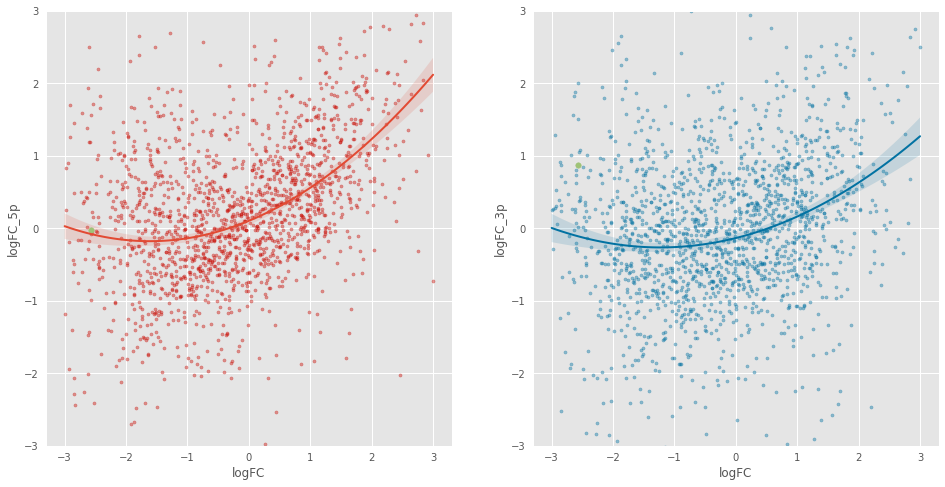

In [132]:
import pydove as dv
fig,ax=plt.subplots(figsize=(16,8),ncols=2)

# generate some data
temp = merge_5_3[(merge_5_3['logFC']>-3) & (merge_5_3['logFC']<3)]
# plot it
#fig, ax = plt.subplots()
res1 = dv.regplot(order=2, data=temp,x='logFC',y='logFC_5p',ax=ax[0]
            ,scatter_kws={'s':10,'alpha':0.4,'c':'r'})

res2 = dv.regplot(order=2, data=temp,x='logFC',y='logFC_3p',ax=ax[1]
            ,scatter_kws={'s':10,'alpha':0.4, 'c':'b'},line_kws={'c':'b'})


merge_5_3[merge_5_3['index']=='KS17gene_3137a'].plot(
kind='scatter',x='logFC',y='logFC_5p',ax=ax[0],c='g',s=30
)

merge_5_3[merge_5_3['index']=='KS17gene_3137a'].plot(
kind='scatter',x='logFC',y='logFC_3p',ax=ax[1],c='g',s=30
)




ax[0].set_ylim(-3,3)
ax[1].set_ylim(-3,3)
#merge_5_3[merge_5_3['gene_sensitive_at_5prime'].isin(select)].plot(
#    kind='scatter', x='logFC', y='logFC_5p', ax=ax[0], s=20, c='k',alpha=1)

#merge_5_3[merge_5_3['gene_sensitive_at_3prime'].isin(select)].plot(
#    kind='scatter', x='logFC', y='logFC_3p', ax=ax[1], s=20, c='k', alpha=1)

In [133]:
merge_all.head()

,Chro,Source,ttype,start,end,orient,desc,gene_id,gene_id_p1,orient_p1,gene_id_m1,orient_m1
27425,Tb927_01_v5.1,VEuPathDB,CDS,381,1961,-,"transcript_id ""Tb927.1.05:mRNA""; gene_id ""Tb92...",Tb927.1.05,NaN,NaN,Tb927.1.10,+
27428,Tb927_01_v5.1,VEuPathDB,CDS,6871,7203,+,"transcript_id ""Tb927.1.10:mRNA""; gene_id ""Tb92...",Tb927.1.10,Tb927.1.05,-,Tb927.1.20,-
27431,Tb927_01_v5.1,VEuPathDB,CDS,7554,8555,-,"transcript_id ""Tb927.1.20:pseudogenic_transcri...",Tb927.1.20,Tb927.1.10,+,Tb927.1.30,+
27434,Tb927_01_v5.1,VEuPathDB,CDS,11158,11865,+,"transcript_id ""Tb927.1.30:mRNA""; gene_id ""Tb92...",Tb927.1.30,Tb927.1.20,-,Tb927.1.40,-
27437,Tb927_01_v5.1,VEuPathDB,CDS,12407,12733,-,"transcript_id ""Tb927.1.40:mRNA""; gene_id ""Tb92...",Tb927.1.40,Tb927.1.30,+,Tb927.1.60,-


In [134]:
print(1)

1


In [135]:
#merge_5_3_all[~merge_5_3_all['index'].str.startswith('KS')]

100%|██████████| 10/10 [00:01<00:00,  9.36it/s]


Text(0.5, 1.0, "3' of lncRNAs")

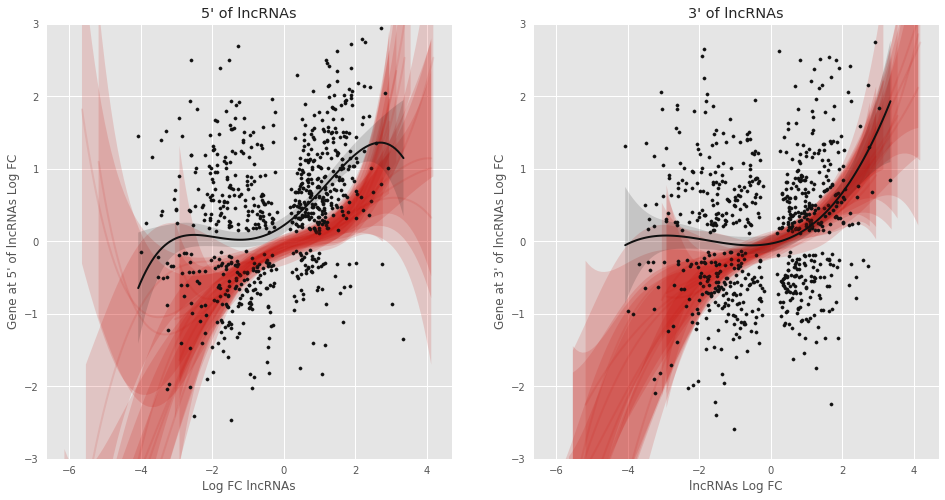

In [136]:
import pydove as dv
fig,ax=plt.subplots(figsize=(16,8),ncols=2)
from tqdm import tqdm
for n in tqdm(range(10)):
    temp = merge_5_3_all[~merge_5_3_all['index'].str.startswith('KS')]
    
    #merge_5_3[merge_5_3['index'].str.startswith('KS')]
    temp = list(temp.sample(1500,random_state=n)['index'].values)
    temp = create_expression_table(merge, temp)
    #temp = temp[(temp['logFC']>-3) & (temp['logFC']<3)]
    temp = temp[(temp['FDR']<0.01) & (temp['FDR_5p']<0.01) & (temp['FDR_3p']<0.01) ]
    #print(temp.shape)
    temp['logFC'].describe()
    # generate some data

    # plot it
    #fig, ax = plt.subplots()
    res1 = dv.regplot(order=4, data=temp,x='logFC',y='logFC_5p',ax=ax[0]
                ,scatter_kws={'s':0,'alpha':0.4,'c':'r'},line_kws={'c':'r','alpha':0.1,})

    res2 = dv.regplot(order=4, data=temp,x='logFC',y='logFC_3p',ax=ax[1]
                ,scatter_kws={'s':0,'alpha':0.4, 'c':'b'},line_kws={'c':'r','alpha':0.1,})

for n in range(1):
    temp = merge_5_3_all[merge_5_3_all['index'].str.startswith('KS')]
    temp = list(temp['index'].values)
    #temp = list(temp.sample(500,random_state=n)['index'].values)
    temp = create_expression_table(merge, temp)
    #temp = temp[(temp['logFC']>-3) & (temp['logFC']<3)]
    temp = temp[(temp['FDR']<0.01) & (temp['FDR_5p']<0.01) & (temp['FDR_3p']<0.01) ]
    #print(temp.shape)
    temp['logFC'].describe()
    # generate some data

    # plot it
    #fig, ax = plt.subplots()
    #if n ==0
    res1 = dv.regplot(order=4, data=temp,x='logFC',y='logFC_5p',ax=ax[0]
                ,scatter_kws={'s':10,'alpha':1,'c':'k'},line_kws={'c':'k'})

    res2 = dv.regplot(order=4, data=temp,x='logFC',y='logFC_3p',ax=ax[1]
                ,scatter_kws={'s':10,'alpha':1, 'c':'k'},line_kws={'c':'k'})
    

#select=['KS17gene_4296a']
#
#merge_5_3_all[merge_5_3_all['index'].isin(select)].plot(
#    kind='scatter', x='logFC', y='logFC_5p', ax=ax[0], s=50, c='k',alpha=1)
#merge_5_3_all[merge_5_3_all['index'].isin(select)].plot(
#    kind='scatter', x='logFC', y='logFC_3p', ax=ax[1], s=50, c='k', alpha=1)    
    
    
ax[0].set_ylim(-3,3)
ax[1].set_ylim(-3,3)
ax[0].set_xlabel('Log FC lncRNAs')
ax[0].set_ylabel('Gene at 5\' of lncRNAs Log FC')
ax[0].set_title('5\' of lncRNAs')

ax[1].set_xlabel('lncRNAs Log FC')
ax[1].set_ylabel('Gene at 3\' of lncRNAs Log FC' )
ax[1].set_title('3\' of lncRNAs')

#try loess

100%|██████████| 1000/1000 [05:59<00:00,  2.78it/s]


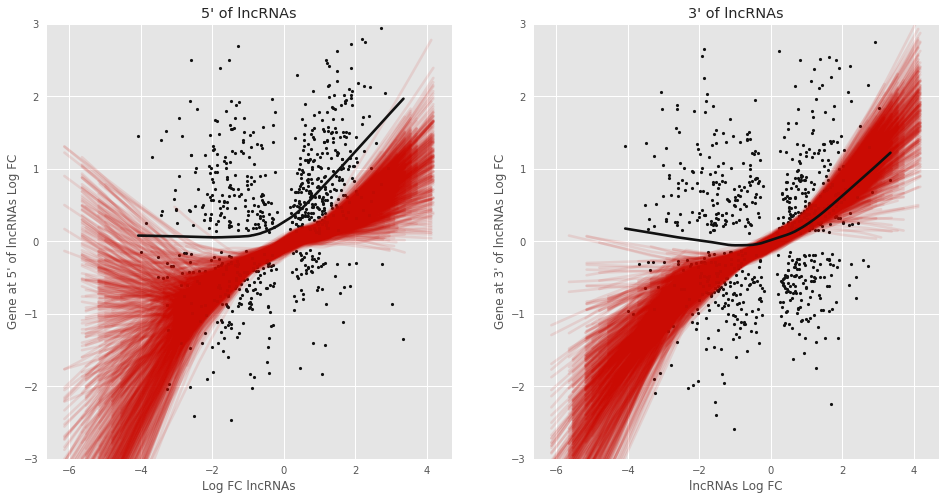

In [137]:
#import pydove as dv
fig,ax=plt.subplots(figsize=(16,8),ncols=2)
from tqdm import tqdm
for n in tqdm(range(1000)):
    temp = merge_5_3_all[~merge_5_3_all['index'].str.startswith('KS')]
    temp = temp[(temp['FDR']<0.01) & (temp['FDR_5p']<0.01) & (temp['FDR_3p']<0.01) ]
    #merge_5_3[merge_5_3['index'].str.startswith('KS')]
    temp = list(temp.sample(1000,random_state=n)['index'].values)
    temp = create_expression_table(merge, temp)
    #temp = temp[(temp['logFC']>-3) & (temp['logFC']<3)]
    
    #print(temp.shape)
    #temp['logFC'].describe()
    # generate some data

    # plot it
    #fig, ax = plt.subplots()
    res1 = sns.regplot(lowess=True, data=temp,x='logFC',y='logFC_5p',ax=ax[0]
                ,scatter_kws={'s':0,'alpha':0.4,'color':'r'},line_kws={'color':'r','alpha':0.1,})
    
    
    

    res2 = sns.regplot(lowess=True, data=temp,x='logFC',y='logFC_3p',ax=ax[1]
                ,scatter_kws={'s':0,'alpha':0.4, 'color':'b'},line_kws={'color':'r','alpha':0.1,})

for n in range(1):
    temp = merge_5_3_all[merge_5_3_all['index'].str.startswith('KS')]
    temp = list(temp['index'].values)
    #temp = list(temp.sample(500,random_state=n)['index'].values)
    temp = create_expression_table(merge, temp)
    #temp = temp[(temp['logFC']>-3) & (temp['logFC']<3)]
    temp = temp[(temp['FDR']<0.01) & (temp['FDR_5p']<0.01) & (temp['FDR_3p']<0.01) ]
    #print(temp.shape)
    temp['logFC'].describe()
    # generate some data

    # plot it
    #fig, ax = plt.subplots()
    #if n ==0
    res1 = sns.regplot(lowess=True, data=temp,x='logFC',y='logFC_5p',ax=ax[0]
                ,scatter_kws={'s':10,'alpha':1,'color':'k'},line_kws={'color':'k'})

    res2 = sns.regplot(lowess=True, data=temp,x='logFC',y='logFC_3p',ax=ax[1]
                ,scatter_kws={'s':10,'alpha':1, 'color':'k'},line_kws={'color':'k'})
    

#select=['KS17gene_4296a']
#
#merge_5_3_all[merge_5_3_all['index'].isin(select)].plot(
#    kind='scatter', x='logFC', y='logFC_5p', ax=ax[0], s=50, c='k',alpha=1)
#merge_5_3_all[merge_5_3_all['index'].isin(select)].plot(
#    kind='scatter', x='logFC', y='logFC_3p', ax=ax[1], s=50, c='k', alpha=1)    
      
ax[0].set_ylim(-3,3)
ax[1].set_ylim(-3,3)
ax[0].set_xlabel('Log FC lncRNAs')
ax[0].set_ylabel('Gene at 5\' of lncRNAs Log FC')
ax[0].set_title('5\' of lncRNAs')

ax[1].set_xlabel('lncRNAs Log FC')
ax[1].set_ylabel('Gene at 3\' of lncRNAs Log FC' )
ax[1].set_title('3\' of lncRNAs')
plt.savefig('New Fig 17.png')
#try loess

100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


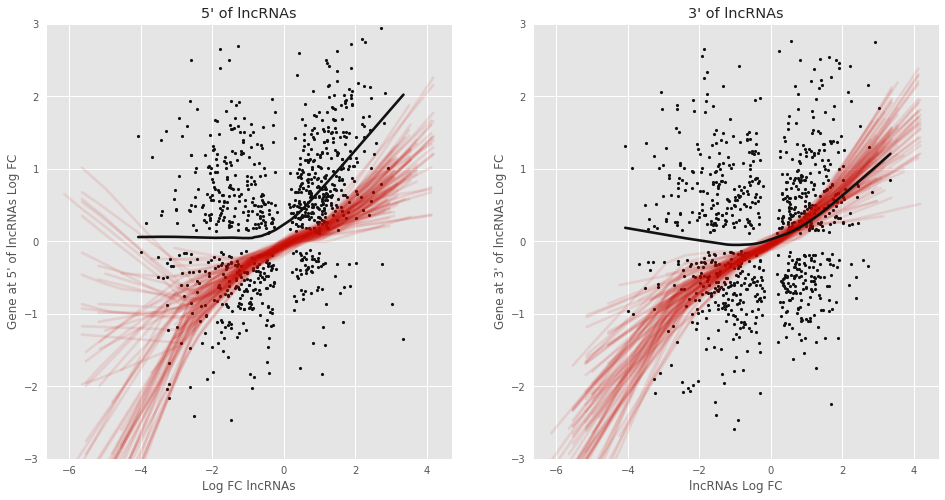

In [138]:
#import pydove as dv
fig,ax=plt.subplots(figsize=(16,8),ncols=2)
from tqdm import tqdm
for n in tqdm(range(100)):
    temp = merge_5_3_all[~merge_5_3_all['index'].str.startswith('KS')]
    temp = temp[(temp['FDR']<0.01) & (temp['FDR_5p']<0.01) ]
    #merge_5_3[merge_5_3['index'].str.startswith('KS')]
    temp = list(temp.sample(1000,random_state=n)['index'].values)
    temp = create_expression_table(merge, temp)
    #temp = temp[(temp['logFC']>-3) & (temp['logFC']<3)]
    
    #print(temp.shape)
    #temp['logFC'].describe()
    # generate some data

    # plot it
    #fig, ax = plt.subplots()
    res1 = sns.regplot(lowess=True, data=temp,x='logFC',y='logFC_5p',ax=ax[0]
                ,scatter_kws={'s':0,'alpha':0.4,'color':'r'},line_kws={'color':'r','alpha':0.1,})
    
    temp = merge_5_3_all[~merge_5_3_all['index'].str.startswith('KS')]
    temp = temp[(temp['FDR']<0.01) & (temp['FDR_3p']<0.01) ]
    #merge_5_3[merge_5_3['index'].str.startswith('KS')]
    temp = list(temp.sample(1000,random_state=n)['index'].values)
    temp = create_expression_table(merge, temp)


    res2 = sns.regplot(lowess=True, data=temp,x='logFC',y='logFC_3p',ax=ax[1]
                ,scatter_kws={'s':0,'alpha':0.4, 'color':'b'},line_kws={'color':'r','alpha':0.1,})

for n in range(1):
    temp = merge_5_3_all[merge_5_3_all['index'].str.startswith('KS')]
    temp = list(temp['index'].values)
    #temp = list(temp.sample(500,random_state=n)['index'].values)
    temp = create_expression_table(merge, temp)
    #temp = temp[(temp['logFC']>-3) & (temp['logFC']<3)]
    temp = temp[(temp['FDR']<0.01) & (temp['FDR_5p']<0.01) ]
    #print(temp.shape)
    #temp['logFC'].describe()
    # generate some data

    # plot it
    #fig, ax = plt.subplots()
    #if n ==0
    res1 = sns.regplot(lowess=True, data=temp,x='logFC',y='logFC_5p',ax=ax[0]
                ,scatter_kws={'s':10,'alpha':1,'color':'k'},line_kws={'color':'k'})
    
    temp = merge_5_3_all[merge_5_3_all['index'].str.startswith('KS')]
    temp = list(temp['index'].values)
    #temp = list(temp.sample(500,random_state=n)['index'].values)
    temp = create_expression_table(merge, temp)
    #temp = temp[(temp['logFC']>-3) & (temp['logFC']<3)]
    temp = temp[(temp['FDR']<0.01) & (temp['FDR_3p']<0.01) ]
 

    res2 = sns.regplot(lowess=True, data=temp,x='logFC',y='logFC_3p',ax=ax[1]
                ,scatter_kws={'s':10,'alpha':1, 'color':'k'},line_kws={'color':'k'})
    

#select=['KS17gene_4296a']
#
#merge_5_3_all[merge_5_3_all['index'].isin(select)].plot(
#    kind='scatter', x='logFC', y='logFC_5p', ax=ax[0], s=50, c='k',alpha=1)
#merge_5_3_all[merge_5_3_all['index'].isin(select)].plot(
#    kind='scatter', x='logFC', y='logFC_3p', ax=ax[1], s=50, c='k', alpha=1)    
      
ax[0].set_ylim(-3,3)
ax[1].set_ylim(-3,3)
ax[0].set_xlabel('Log FC lncRNAs')
ax[0].set_ylabel('Gene at 5\' of lncRNAs Log FC')
ax[0].set_title('5\' of lncRNAs')

ax[1].set_xlabel('lncRNAs Log FC')
ax[1].set_ylabel('Gene at 3\' of lncRNAs Log FC' )
ax[1].set_title('3\' of lncRNAs')
plt.savefig('New Fig 17.png')
#try loess

In [139]:
temp = merge_5_3_all[merge_5_3_all['index'].str.startswith('KS')]
temp = list(temp['index'].values)
    #temp = list(temp.sample(500,random_state=n)['gene_id'].values)
temp = create_expression_table(merge, temp)
#temp = temp[(temp['logFC']>-3) & (temp['logFC']<3)]
temp = temp[(temp['FDR']<0.01) & (temp['FDR_5p']<0.01) & (temp['FDR_3p']<0.01) ]
temp.shape

(722, 15)

In [140]:
temp.head()

,gene_id,Chro,Source,ttype,start,end,orient,gene_sensitive_at_5prime,gene_sensitive_at_3prime,logFC,FDR,logFC_5p,FDR_5p,logFC_3p,FDR_3p
2,KS17gene_34a,Tb927_01_v5.1,FGuegan,CDS,149570,151104,+,Tb927.1.400,Tb927.1.410,-3.255398,0.000000e+00,-0.871556,1.326644e-13,1.179337,7.993808e-84
6,KS17gene_52a,Tb927_01_v5.1,FGuegan,CDS,393782,394635,+,Tb927.1.1530,Tb927.1.1540,-2.406571,2.331107e-161,0.720023,1.619987e-22,0.709093,9.137172e-42
8,KS17gene_61a,Tb927_01_v5.1,FGuegan,CDS,436757,436827,+,Tb927.1.1710,Tb927.1.1720,0.682530,2.465851e-05,-0.355767,2.297398e-07,0.172709,8.120356e-05
9,KS17gene_68a,Tb927_01_v5.1,FGuegan,CDS,469536,470002,+,Tb927.1.1790,Tb927.1.1820,0.791962,1.835640e-19,1.005239,5.253004e-50,-0.242479,2.526227e-04
10,KS17gene_70a,Tb927_01_v5.1,FGuegan,CDS,473180,473786,+,Tb927.1.1820,Tb927.1.1840,0.836796,5.356815e-08,-0.242479,2.526227e-04,0.908961,1.585447e-21


In [141]:
print(temp[temp['logFC']>0].shape[0])
print(temp[temp['logFC']<0].shape[0])
print(temp[temp['logFC_5p']>0].shape[0])
print(temp[temp['logFC_5p']<0].shape[0])

362
360
488
234


In [142]:
print(temp[temp['logFC']>0].shape[0])
print(temp[temp['logFC']<0].shape[0])
print(temp[temp['logFC_3p']>0].shape[0])
print(temp[temp['logFC_3p']<0].shape[0])

362
360
400
322


In [145]:
from statsmodels.stats.contingency_tables import  mcnemar 

temp = merge_5_3_all[merge_5_3_all['index'].str.startswith('KS')]
temp = list(temp['index'].values)
    #temp = list(temp.sample(500,random_state=n)['gene_id'].values)
temp = create_expression_table(merge, temp)
temp = temp[(temp['FDR']<0.01) & (temp['FDR_5p']<0.01)]




a=temp[temp['logFC']>0].shape[0]+temp[temp['logFC_5p']>0].shape[0]
b=temp[temp['logFC']>0].shape[0]+temp[temp['logFC_5p']<0].shape[0]
c=temp[temp['logFC']<0].shape[0]+temp[temp['logFC_5p']>0].shape[0]
d=temp[temp['logFC']<0].shape[0]+temp[temp['logFC_5p']<0].shape[0]
observed = np.array([[a, b],
                     [c, d]])



print(mcnemar(observed,exact=False))

pvalue      9.597721802432467e-14
statistic   55.44773519163763


In [146]:
temp = merge_5_3_all[merge_5_3_all['index'].str.startswith('KS')]
temp = list(temp['index'].values)
    #temp = list(temp.sample(500,random_state=n)['gene_id'].values)
temp = create_expression_table(merge, temp)
temp = temp[(temp['FDR']<0.01) & (temp['FDR_3p']<0.01)]

a=temp[temp['logFC']>0].shape[0]+temp[temp['logFC_3p']>0].shape[0]
b=temp[temp['logFC']>0].shape[0]+temp[temp['logFC_3p']<0].shape[0]
c=temp[temp['logFC']<0].shape[0]+temp[temp['logFC_3p']>0].shape[0]
d=temp[temp['logFC']<0].shape[0]+temp[temp['logFC_3p']<0].shape[0]
observed = np.array([[a, b],
                     [c, d]])

print(mcnemar(observed,exact=False))

pvalue      0.00488406301054759
statistic   7.921875


In [149]:
import numpy as np
from scipy.stats import chi2_contingency 
# using Pearson’s chi-squared statistic
# corrected for the Yates’ continuity
observed = np.array([[temp[temp['logFC']>0].shape[0], temp[temp['logFC']<0].shape[0]],
                     [temp[temp['logFC_5p']>0].shape[0], temp[temp['logFC_5p']<0].shape[0]]])
chi_val, p_val, dof, expected =  chi2_contingency(observed)
chi_val, p_val, dof, expected

(42.76031370163585, 6.187479529190287e-11, 1, array([[482., 382.],
        [482., 382.]]))

In [150]:
import numpy as np
from scipy.stats import chi2_contingency 
# using Pearson’s chi-squared statistic
# corrected for the Yates’ continuity
observed = np.array([[temp[temp['logFC']>0].shape[0], temp[temp['logFC']<0].shape[0]],
                     [temp[temp['logFC_3p']>0].shape[0], temp[temp['logFC_3p']<0].shape[0]]])
chi_val, p_val, dof, expected =  chi2_contingency(observed)
chi_val, p_val, dof, expected

(7.792559188275085, 0.005246183323187374, 1, array([[443.5, 420.5],
        [443.5, 420.5]]))

In [155]:
temp = temp.rename({'index':'gene_ks'},axis=1)
temp['Desc_5p']=[desc_dict.get(n,'none') for n in temp['gene_sensitive_at_5prime']]
temp['Desc_3p']=[desc_dict.get(n,'none') for n in temp['gene_sensitive_at_3prime']]
temp.head()

,gene_id,Chro,Source,ttype,start,end,orient,gene_sensitive_at_5prime,gene_sensitive_at_3prime,logFC,FDR,logFC_5p,FDR_5p,logFC_3p,FDR_3p,Desc_5p,Desc_3p
0,KS17gene_30a,Tb927_01_v5.1,FGuegan,CDS,107289,107927,+,Tb927.1.270,Tb927.1.275,-1.201911,4.296802e-88,0.032509,7.429151e-01,-0.635963,1.762024e-08,hypothetical protein,expression site-associated gene 4 (ESAG4) pse...
2,KS17gene_34a,Tb927_01_v5.1,FGuegan,CDS,149570,151104,+,Tb927.1.400,Tb927.1.410,-3.255398,0.000000e+00,-0.871556,1.326644e-13,1.179337,7.993808e-84,hypothetical protein conserved,retrotransposon hot spot protein (RHS pseudog...
3,KS17gene_37a,Tb927_01_v5.1,FGuegan,CDS,187252,187918,+,Tb927.1.480,Tb927.1.490,-0.779658,3.903796e-21,-0.161633,5.313207e-02,-1.773256,6.080487e-31,leucine-rich repeat protein (LRRP) putative,hypothetical protein
6,KS17gene_52a,Tb927_01_v5.1,FGuegan,CDS,393782,394635,+,Tb927.1.1530,Tb927.1.1540,-2.406571,2.331107e-161,0.720023,1.619987e-22,0.709093,9.137172e-42,STE group serine/threonine-protein kinase put...,Tubulin/FtsZ family putative
8,KS17gene_61a,Tb927_01_v5.1,FGuegan,CDS,436757,436827,+,Tb927.1.1710,Tb927.1.1720,0.682530,2.465851e-05,-0.355767,2.297398e-07,0.172709,8.120356e-05,transmembrane protein conserved,cyclophilin 15 putative


In [156]:
ptr = pd.read_csv('../polisome/InData/PTR.txt',sep='\t')
ptr = ptr.drop_duplicates('gene_id')
#ptr.set_index('gene_id',inplace=True)
ptr = dict(zip(ptr['gene_id'],ptr['reg_type']))
#ptr

In [157]:
temp['is_PTR_5p'] =[ptr.get(n,'none') for n in temp['gene_sensitive_at_5prime']]
temp['is_PTR_3p'] =[ptr.get(n,'none') for n in temp['gene_sensitive_at_3prime']]

In [161]:
#temp['is_PTR_3p'].value_counts()

none        809
increase     32
decrease     23
Name: is_PTR_3p, dtype: int64

In [229]:
temp.rename({'gene_id':'gene_ks'},axis=1,inplace=True)
temp[['gene_ks','gene_sensitive_at_5prime','gene_sensitive_at_3prime',
                    
                    'logFC','FDR','logFC_5p','FDR_5p','logFC_3p','FDR_3p','Desc_5p','Desc_3p','is_PTR_5p',
     'is_PTR_3p']].to_csv('Tables/Table_6.csv')
                    #'PValue','FDR','reg_type','desc','selected']]#.to_csv('Tables/Table_6.csv')

In [ ]:
#merge_5_3.head()

In [ ]:
#merge.loc['KS17gene_3137a']

In [234]:
#temp = merge_5_3_all[merge_5_3_all['index'].str.startswith('KS')]
#temp.head()

,index,Chro,Source,ttype,start,end,orient,gene_sensitive_at_5prime,gene_sensitive_at_3prime,logFC,FDR,logFC_5p,FDR_5p,logFC_3p,FDR_3p
0,KS17gene_1000a,Tb927_05_v5.1,FGuegan,CDS,1175464,1176229,+,Tb927.5.3560,Tb927.5.3570,1.377558,4.743136e-96,1.846657,4.919981e-236,0.627497,1.062314e-45
1,KS17gene_1005a,Tb927_05_v5.1,FGuegan,CDS,1182048,1182196,+,Tb927.5.3590,Tb927.5.3600,1.323130,9.408186e-35,0.612775,3.428206e-39,0.150109,9.136230e-04
2,KS17gene_1009a,Tb927_05_v5.1,FGuegan,CDS,1189831,1190335,+,Tb927.5.3610,Tb927.5.3620,1.779649,4.178559e-21,0.608685,5.608914e-26,1.865994,8.281921e-19
3,KS17gene_1016a,Tb927_05_v5.1,FGuegan,CDS,1216515,1217277,+,Tb927.5.3700,Tb927.5.3710,0.552993,2.953497e-14,0.455212,9.460529e-14,0.000404,9.949735e-01
4,KS17gene_1022a,Tb927_05_v5.1,FGuegan,CDS,1225007,1225191,+,Tb927.5.3745,Tb927.5.3750,-0.380676,5.836531e-05,-0.135355,4.028446e-02,-0.821143,1.988319e-50
